## **1. Setup**

### **1.1 RAPIDS Installation**

[RAPIDS](https://rapids.ai/index.html) is a data science framework which includes a set of libraries for executing end-to-end data science pipelines completely in the GPU. It is very similar to NumPy, pandas and scikit-learn and it workes completely in the GPU. RAPIDS is not available in Kaggle Docker environment so it has to be installed manually.

This notebook includes codes and ideas from notebooks below. Don't forget to upvote their work as well.

* [RAPIDS SVM on TReNDS Neuroimaging - Ahmet Erdem](https://www.kaggle.com/aerdem4/rapids-svm-on-trends-neuroimaging) by [@aerdem4](https://www.kaggle.com/aerdem4)
* [RAPIDS Ensemble for TReNDS Neuroimaging - Bojan Tunguz](https://www.kaggle.com/tunguz/rapids-ensemble-for-trends-neuroimaging) by [@tunguz](https://www.kaggle.com/tunguz)

In [1]:
import sys

!cp ../input/rapids/rapids.0.13.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ['/opt/conda/envs/rapids/lib/python3.6/site-packages'] + sys.path
sys.path = ['/opt/conda/envs/rapids/lib/python3.6'] + sys.path
sys.path = ['/opt/conda/envs/rapids/lib'] + sys.path
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

import cudf
import cupy as cp
import cuml

print(f'cuDF Version: {cudf.__version__}\ncuPY Version: {cp.__version__}\ncuML Version: {cuml.__version__}')

cuDF Version: 0.13.0
cuPY Version: 7.5.0
cuML Version: 0.13.0


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

SEED = 7021991

The pickle file (`trends_tabular_data.pkl`) is loaded from [this](https://www.kaggle.com/gunesevitan/trends-neuroimaging-data-analysis-matlab-files) notebook. There are lots new features created in that notebook's *6. Feature Engineering* section and feature engineering process has a detailed data analysis and explanation.

There are additional 689 statistical features and 1590 bounding box features extracted from `fMRI_train` and `fMRI_test`. Those features have to be scaled with `StandardScaler` because they are on a different scale. `RobustScaler` yields worse results compared to `StandardScaler`.

In [3]:
df = pd.read_pickle('../input/trends-neuroimaging-data-analysis-3d-features/trends_tabular_data.pkl')
df_fnc = pd.read_csv('../input/trends-assessment-prediction/fnc.csv')
df_loading = pd.read_csv('../input/trends-assessment-prediction/loading.csv')

fnc_features = [feature for feature in df_fnc.columns.tolist()[1:]]
shifted_loading_features = ['IC_18', 'IC_20']
loading_features = [feature for feature in df_loading.columns.tolist()[1:] if feature not in shifted_loading_features]
target_features = ['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']
utility_features = ['is_train', 'site', 'site_predicted']
spatial_features = [feature for feature in df.columns.tolist()[1:] if feature not in fnc_features and 
                                                                      feature not in loading_features and
                                                                      feature not in shifted_loading_features and 
                                                                      feature not in target_features and 
                                                                      feature not in utility_features]

df.loc[:, spatial_features] = StandardScaler().fit_transform(df[spatial_features])

boundingbox_features = [feature for feature in spatial_features if 'box' in feature]
statistical_features = [feature for feature in spatial_features if 'box' not in feature]

print(f'TReNDS Neuroimaging - Tabular Data Shape = {df.shape}')
print(f'TReNDS Neuroimaging - Tabular Data Memory Usage = {df.memory_usage().sum() / 1024 ** 2:.2f} MB')

del df_fnc, df_loading, shifted_loading_features

TReNDS Neuroimaging - Tabular Data Shape = (11754, 3692)
TReNDS Neuroimaging - Tabular Data Memory Usage = 330.87 MB


### **1.2 Train/Test Split and Feature/Sample Selection**

Training and test set are split by `is_train` flag and utility features are dropped. Features with large mean shifts (`IC_18` and `IC_20`) are dropped. There was one extreme outlier in `IC_02` and it is also dropped.

In [4]:
df_train = df[df['is_train'] == 1].copy(deep=True).drop(columns=utility_features).reset_index(drop=True)
df_test = df[df['is_train'] == 0].copy(deep=True).drop(columns=(target_features + utility_features)).reset_index(drop=True)

df_train['is_filtered'] = 0
df_train.loc[df_train['IC_02'] < -0.02, 'is_filtered'] = 1

filtered_idx = df_train[df_train['is_filtered'] == 1].index
df_train.drop(filtered_idx, inplace=True)
df_train.drop(columns=['is_filtered'], inplace=True)

print(f'Training Data Shape = {df_train.shape}')
print(f'Training Data Memory Usage = {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Data Shape = {df_test.shape}')
print(f'Test Data Memory Usage = {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

del df, filtered_idx, utility_features

Training Data Shape = (5876, 3689)
Training Data Memory Usage = 165.39 MB
Test Data Shape = (5877, 3684)
Test Data Memory Usage = 165.15 MB


## **2. Linear Model Ensemble**

`LinearModelEnsemble` is a wrapper of `sklearn.linear_model.Ridge` and `cuml.SVR`. It enables to train same models with minor changes. Those changes are random feature drops from different feature groups and using different seeds in cross-validation techniques. Those changes are done at the start of every round and they help to create more robust predictions because single models are oversensitive.

It has feature fraction functionality for every different feature groups (Loading, FNC, Statistical and Bounding Box). Those feature fraction parameters has to be implemented seperately because an imbalanced feature drop from a specific feature group hurts the models' performance drastically. The largest boost is coming from loading features so `loading_fraction` must be set to `1.0`, and other feature fraction parameters should be between `0.9` and `1.0`. If feature fractions are below `1.0`, predictions have to be created with decent amount of rounds so they can be reliable.

It creates the splits with different seed in every round, however, this functionality requires cross-validations with shuffle. Otherwise, data in the folds are going to be same in every round.

In [5]:
class LinearModelEnsemble:
    
    def __init__(self, model, model_name, model_features, model_parameters, cv, n_rounds, loading_fraction, fnc_fraction, statistical_fraction, boundingbox_fraction, verbose):
        
        self.target_weights = np.array([0.3, 0.175, 0.175, 0.175, 0.175])        
        self.target_idx = {
            'age': df_train.loc[~df_train['age'].isnull()].index,
            'domain1_var1': df_train.loc[~df_train['domain1_var1'].isnull()].index,
            'domain1_var2': df_train.loc[~df_train['domain1_var2'].isnull()].index,
            'domain2_var1': df_train.loc[~df_train['domain2_var1'].isnull()].index,
            'domain2_var2': df_train.loc[~df_train['domain2_var2'].isnull()].index         
        }
        self.random_states = [1337, 5041992, 7021991, 42, 0]
        
        self.model = model
        self.model_name = model_name
        self.model_features = model_features
        self.model_parameters = model_parameters
        self.cv = cv        
        self.n_rounds = n_rounds
        self.loading_fraction = loading_fraction
        self.fnc_fraction = fnc_fraction
        self.statistical_fraction = statistical_fraction
        self.boundingbox_fraction = boundingbox_fraction
        self.verbose = verbose
                 
    def normalized_absolute_error(self, y_true, y_pred):
        return np.mean(np.sum(np.abs(y_true - y_pred)) / np.sum(y_true))
                       
    def _ridge_train_and_predict(self, X_train, y_train, X_test, cv, r):
        
        self.ridge_scores = {
            'age': [],
            'domain1_var1': [],
            'domain1_var2': [],
            'domain2_var1': [],
            'domain2_var2': [],
        }
        
        self.ridge_oof_scores = []
                
        for i, target in enumerate(target_features):
            
            if self.verbose:
                print(f'\nFitting {target}\n{(len(target) + 8) * "-"}')
            
            X_trn = X_train.loc[self.target_idx[target], self.model_features[target]].copy(deep=True)
            y_trn = y_train.loc[self.target_idx[target], target].copy(deep=True)
            train_predictions = pd.DataFrame(y_trn.copy(deep=True))
            
            if r == 0:
                df_train[f'{self.model_name}_{target}'] = 0
                df_test[f'{self.model_name}_{target}'] = 0
                                    
            for fold, (trn_idx, val_idx) in enumerate(cv.split(X_trn), 1):
                
                trn_data = X_trn.iloc[trn_idx, :]
                trn_labels = y_trn.iloc[trn_idx]
                val_data = X_trn.iloc[val_idx, :]
                val_labels = y_trn.iloc[val_idx]
                
                ridge_regression = Ridge(**self.model_parameters[target])
                ridge_regression.fit(trn_data, trn_labels)
                
                fold_train_predictions = ridge_regression.predict(val_data)
                df_train.loc[X_trn.iloc[val_idx, :].index, f'{self.model_name}_{target}'] += (fold_train_predictions / self.n_rounds)
                train_predictions.loc[X_trn.iloc[val_idx, :].index, target] = fold_train_predictions

                fold_test_predictions = ridge_regression.predict(X_test.loc[:, self.model_features[target]])
                df_test.loc[X_test.index, f'{self.model_name}_{target}'] += ((fold_test_predictions / cv.n_splits) / self.n_rounds)
                                
                ridge_score = self.normalized_absolute_error(val_labels.values, fold_train_predictions)
                self.ridge_scores[target].append(ridge_score)
                if self.verbose:
                    print(f'Fold {fold} - Ridge Regression NAE {ridge_score:.6}')
            
            oof_nae = self.normalized_absolute_error(df_train.loc[self.target_idx[target], target], train_predictions[target])
            self.ridge_oof_scores.append(oof_nae)
            if self.verbose:
                print(f'{52 * "-"}\nRidge Regression ({target}) Mean NAE {np.mean(self.ridge_scores[target]):.6} [STD:{np.std(self.ridge_scores[target]):.6}]')
            print(f'Ridge Regression ({target}) OOF NAE {oof_nae:.6}')
            
        weighted_nae = np.sum(np.array(self.ridge_oof_scores) * self.target_weights)
        print(f'{52 * "-"}\nRidge Regression Global Weighted NAE {weighted_nae:.6}')
                
    def _svr_train_and_predict(self, X_train, y_train, X_test, cv, r):          
        
        self.svr_scores = {
            'age': [],
            'domain1_var1': [],
            'domain1_var2': [],
            'domain2_var1': [],
            'domain2_var2': [],
        }
        
        self.svr_oof_scores = []
                
        for i, target in enumerate(target_features):
            
            if self.verbose:
                print(f'\nFitting {target}\n{(len(target) + 8) * "-"}')
            
            X_trn = X_train.loc[self.target_idx[target], self.model_features[target]].copy(deep=True)
            y_trn = y_train.loc[self.target_idx[target], target].copy(deep=True)
            train_predictions = pd.DataFrame(y_trn.copy(deep=True))
            
            if r == 0:
                df_train[f'{self.model_name}_{target}'] = 0
                df_test[f'{self.model_name}_{target}'] = 0
                    
            for fold, (trn_idx, val_idx) in enumerate(cv.split(X_trn), 1):
                
                trn_data = X_trn.iloc[trn_idx, :]
                trn_labels = y_trn.iloc[trn_idx]
                val_data = X_trn.iloc[val_idx, :]
                val_labels = y_trn.iloc[val_idx]
                
                svr_model = cuml.SVR(**self.model_parameters[target])
                svr_model.fit(trn_data.values, trn_labels.values)
                
                fold_train_predictions = svr_model.predict(val_data.values)
                df_train.loc[X_trn.iloc[val_idx, :].index, f'{self.model_name}_{target}'] += (cp.asnumpy(fold_train_predictions.values) / self.n_rounds)
                train_predictions.loc[X_trn.iloc[val_idx, :].index, target] = fold_train_predictions

                fold_test_predictions = svr_model.predict(X_test.loc[:, self.model_features[target]].values)
                df_test.loc[X_test.index, f'{self.model_name}_{target}'] += ((cp.asnumpy(fold_test_predictions.values) / cv.n_splits) / self.n_rounds)
                                                
                svr_score = self.normalized_absolute_error(val_labels.values, cp.asnumpy(fold_train_predictions.values))
                self.svr_scores[target].append(svr_score)  
                if self.verbose:
                    print(f'Fold {fold} - SVR NAE {svr_score:.6}')
            
            oof_nae = self.normalized_absolute_error(df_train.loc[self.target_idx[target], target], train_predictions[target])
            self.svr_oof_scores.append(oof_nae)
            
            if self.verbose:
                print(f'{52 * "-"}\nSVR ({target}) Mean NAE {np.mean(self.svr_scores[target]):.6} [STD:{np.std(self.svr_scores[target]):.6}]')
            print(f'SVR ({target}) OOF NAE {oof_nae:.6}')
            
        weighted_nae = np.sum(np.array(self.svr_oof_scores) * self.target_weights)
        print(f'{52 * "-"}\nSVR Global Weighted NAE {weighted_nae:.6}')
                
    def plot_regression(self):
        
        fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25, 50))
        
        for i, target in enumerate(target_features):
            
            target_oof_predictions = df_train.loc[self.target_idx[target], f'{self.model_name}_{target}']
            target_y_true = df_train.loc[self.target_idx[target], target]  
            target_test_predictions = df_test.loc[:, f'{self.model_name}_{target}']
                        
            sns.scatterplot(target_y_true, target_oof_predictions, ax=axes[i][0])
            sns.distplot(target_oof_predictions, label='Train Predictions', ax=axes[i][1])
            sns.distplot(target_test_predictions, label='Test Predictions', ax=axes[i][1])
            
            axes[i][0].set_xlabel(f'Labels', size=18)
            axes[i][0].set_ylabel(f'OOF Predictions', size=18)
            axes[i][1].set_xlabel('')
            axes[i][1].legend(prop={'size': 18})
            for j in range(2):
                axes[i][j].tick_params(axis='x', labelsize=15)
                axes[i][j].tick_params(axis='y', labelsize=15)
            axes[i][0].set_title(f'{target} Labels vs OOF Predictions', size=20, pad=20)
            axes[i][1].set_title(f'{target} Predictions Distributions', size=20, pad=20)
            
        plt.show()       
        
    def run(self, X_train, y_train, X_test):
        
        if self.model == 'RidgeRegression':   
            print(f'\n########## Running Ridge Regression Model ##########\n{52 * "-"}')
            
            for r in range(self.n_rounds):                  
                self.cv.random_state = self.random_states[r]
                print(f'\nRound {r + 1} - Seed {self.cv.random_state}\n{(14 + len(str(self.cv.random_state)) + len(str(r))) * "-"}')
                
                if self.loading_fraction < 1.0:
                    np.random.seed(self.random_states[r])
                    loading_feature_count = int(np.ceil(len(loading_features) * self.loading_fraction))
                    loading_drop_features = list(set(loading_features) - set(np.random.choice(loading_features, loading_feature_count, replace=False)))
                else:
                    loading_drop_features = []
                print(f'Dropped {len(loading_drop_features)}/{len(loading_features)} Random Loading Features')
                
                if self.fnc_fraction < 1.0:
                    np.random.seed(self.random_states[r])
                    fnc_feature_count = int(np.ceil(len(fnc_features) * self.fnc_fraction))
                    fnc_drop_features = list(set(fnc_features) - set(np.random.choice(fnc_features, fnc_feature_count, replace=False)))
                else:
                    fnc_drop_features = []
                print(f'Dropped {len(fnc_drop_features)}/{len(fnc_features)} Random FNC Features')
                
                if self.statistical_fraction < 1.0:
                    np.random.seed(self.random_states[r])
                    statistical_feature_count = int(np.ceil(len(statistical_features) * self.statistical_fraction))
                    statistical_drop_features = list(set(statistical_features) - set(np.random.choice(statistical_features, statistical_feature_count, replace=False)))
                else:
                    statistical_drop_features = []
                print(f'Dropped {len(statistical_drop_features)}/{len(statistical_features)} Random Statistical Features')
                
                if self.boundingbox_fraction < 1.0:
                    np.random.seed(self.random_states[r])
                    boundingbox_feature_count = int(np.ceil(len(boundingbox_features) * self.boundingbox_fraction))
                    boundingbox_drop_features = list(set(boundingbox_features) - set(np.random.choice(boundingbox_features, boundingbox_feature_count, replace=False)))
                else:
                    boundingbox_drop_features = []
                print(f'Dropped {len(boundingbox_drop_features)}/{len(boundingbox_features)} Random Bounding Box Features')
                
                drop_features = loading_drop_features + fnc_drop_features + statistical_drop_features + boundingbox_drop_features
                self.model_features = {
                    'age': [feature for feature in self.model_features['age'] if feature not in drop_features],
                    'domain1_var1': [feature for feature in self.model_features['domain1_var1'] if feature not in drop_features],
                    'domain1_var2': [feature for feature in self.model_features['domain1_var2'] if feature not in drop_features],
                    'domain2_var1': [feature for feature in self.model_features['domain2_var1'] if feature not in drop_features],
                    'domain2_var2': [feature for feature in self.model_features['domain2_var2'] if feature not in drop_features]
                }               
                
                self._ridge_train_and_predict(X_train, y_train, X_test, cv=self.cv, r=r)              
                
            print(f'\nFinal Results (Blend of {self.n_rounds} Rounds)\n{(32 + len(str(self.n_rounds))) * "-"}')
            self.blend_oof_scores = []
            
            for target in target_features:
                blend_oof_nae = self.normalized_absolute_error(df_train.loc[self.target_idx[target], target], df_train.loc[self.target_idx[target], f'{self.model_name}_{target}'])
                self.blend_oof_scores.append(blend_oof_nae)
                print(f'Ridge Regression ({target}) Rounds OOF NAE {blend_oof_nae:.6}')
            weighted_nae = np.sum(np.array(self.blend_oof_scores) * self.target_weights)
            print(f'{52 * "-"}\nRidge Regression Global Weighted NAE {weighted_nae:.6}')
                
        elif self.model == 'SVR':            
            print(f'\n########## Running SVR Model ##########\n{39 * "-"}')
            
            for r in range(self.n_rounds):                
                self.cv.random_state = self.random_states[r]
                print(f'\nRound {r + 1} - Seed {self.cv.random_state}\n{(14 + len(str(self.cv.random_state)) + len(str(r))) * "-"}')
                
                if self.loading_fraction < 1.0:
                    np.random.seed(self.random_states[r])
                    loading_feature_count = int(np.ceil(len(loading_features) * self.loading_fraction))
                    loading_drop_features = list(set(loading_features) - set(np.random.choice(loading_features, loading_feature_count, replace=False)))
                else:
                    loading_drop_features = []
                print(f'Dropped {len(loading_drop_features)}/{len(loading_features)} Random Loading Features')
                
                if self.fnc_fraction < 1.0:
                    np.random.seed(self.random_states[r])
                    fnc_feature_count = int(np.ceil(len(fnc_features) * self.fnc_fraction))
                    fnc_drop_features = list(set(fnc_features) - set(np.random.choice(fnc_features, fnc_feature_count, replace=False)))
                else:
                    fnc_drop_features = []
                print(f'Dropped {len(fnc_drop_features)}/{len(fnc_features)} Random FNC Features')
                
                if self.statistical_fraction < 1.0:
                    np.random.seed(self.random_states[r])
                    statistical_feature_count = int(np.ceil(len(statistical_features) * self.statistical_fraction))
                    statistical_drop_features = list(set(statistical_features) - set(np.random.choice(statistical_features, statistical_feature_count, replace=False)))
                else:
                    statistical_drop_features = []
                print(f'Dropped {len(statistical_drop_features)}/{len(statistical_features)} Random Statistical Features')
                
                if self.boundingbox_fraction < 1.0:
                    np.random.seed(self.random_states[r])
                    boundingbox_feature_count = int(np.ceil(len(boundingbox_features) * self.boundingbox_fraction))
                    boundingbox_drop_features = list(set(boundingbox_features) - set(np.random.choice(boundingbox_features, boundingbox_feature_count, replace=False)))
                else:
                    boundingbox_drop_features = []
                print(f'Dropped {len(boundingbox_drop_features)}/{len(boundingbox_features)} Random Bounding Box Features')
                
                drop_features = loading_drop_features + fnc_drop_features + statistical_drop_features + boundingbox_drop_features
                self.model_features = {
                    'age': [feature for feature in self.model_features['age'] if feature not in drop_features],
                    'domain1_var1': [feature for feature in self.model_features['domain1_var1'] if feature not in drop_features],
                    'domain1_var2': [feature for feature in self.model_features['domain1_var2'] if feature not in drop_features],
                    'domain2_var1': [feature for feature in self.model_features['domain2_var1'] if feature not in drop_features],
                    'domain2_var2': [feature for feature in self.model_features['domain2_var2'] if feature not in drop_features]
                }      
                
                self._svr_train_and_predict(X_train, y_train, X_test, cv=self.cv, r=r)
                
            print(f'\nFinal Results (Blend of {self.n_rounds} Rounds)\n{(32 + len(str(self.n_rounds))) * "-"}')
            self.blend_oof_scores = []
            
            for target in target_features:
                blend_oof_nae = self.normalized_absolute_error(df_train.loc[self.target_idx[target], target], df_train.loc[self.target_idx[target], f'{self.model_name}_{target}'])
                self.blend_oof_scores.append(blend_oof_nae)
                print(f'SVR ({target}) Rounds OOF NAE {blend_oof_nae:.6}')
            weighted_nae = np.sum(np.array(self.blend_oof_scores) * self.target_weights)
            print(f'{39 * "-"}\nSVR Global Weighted NAE {weighted_nae:.6}')
            
        self.plot_regression()


## **3. Models Trained without FNC Features**

FNC features improve `age` model's score a lot but they don't contribute much to other targets' models. Models trained without FNC features introduce diversity for the predictions of `domain1_var1`, `domain1_var2`, `domain2_var1` and `domain2_var2`. Predictions of the models without FNC Features are not used in the blend of `age`, but they make the 1% of other targets' blends.

Statistical features and bounding box features are scaled by 5000, and ±0.1 random noise added to `age` for increasing cardinality. 10 split regular `KFold` with shuffle is used as the cross-validation technique. 

### **3.1 Ridge Regression**


########## Running Ridge Regression Model ##########
----------------------------------------------------

Round 1 - Seed 1337
-------------------
Dropped 0/24 Random Loading Features
Dropped 0/1378 Random FNC Features
Dropped 0/689 Random Statistical Features
Dropped 79/1590 Random Bounding Box Features
Ridge Regression (age) OOF NAE 0.145103
Ridge Regression (domain1_var1) OOF NAE 0.151052
Ridge Regression (domain1_var2) OOF NAE 0.15117
Ridge Regression (domain2_var1) OOF NAE 0.181914
Ridge Regression (domain2_var2) OOF NAE 0.17657
----------------------------------------------------
Ridge Regression Global Weighted NAE 0.159155

Round 2 - Seed 5041992
----------------------
Dropped 0/24 Random Loading Features
Dropped 0/1378 Random FNC Features
Dropped 0/689 Random Statistical Features
Dropped 79/1590 Random Bounding Box Features
Ridge Regression (age) OOF NAE 0.1449
Ridge Regression (domain1_var1) OOF NAE 0.150954
Ridge Regression (domain1_var2) OOF NAE 0.15114
Ridge Regression (d

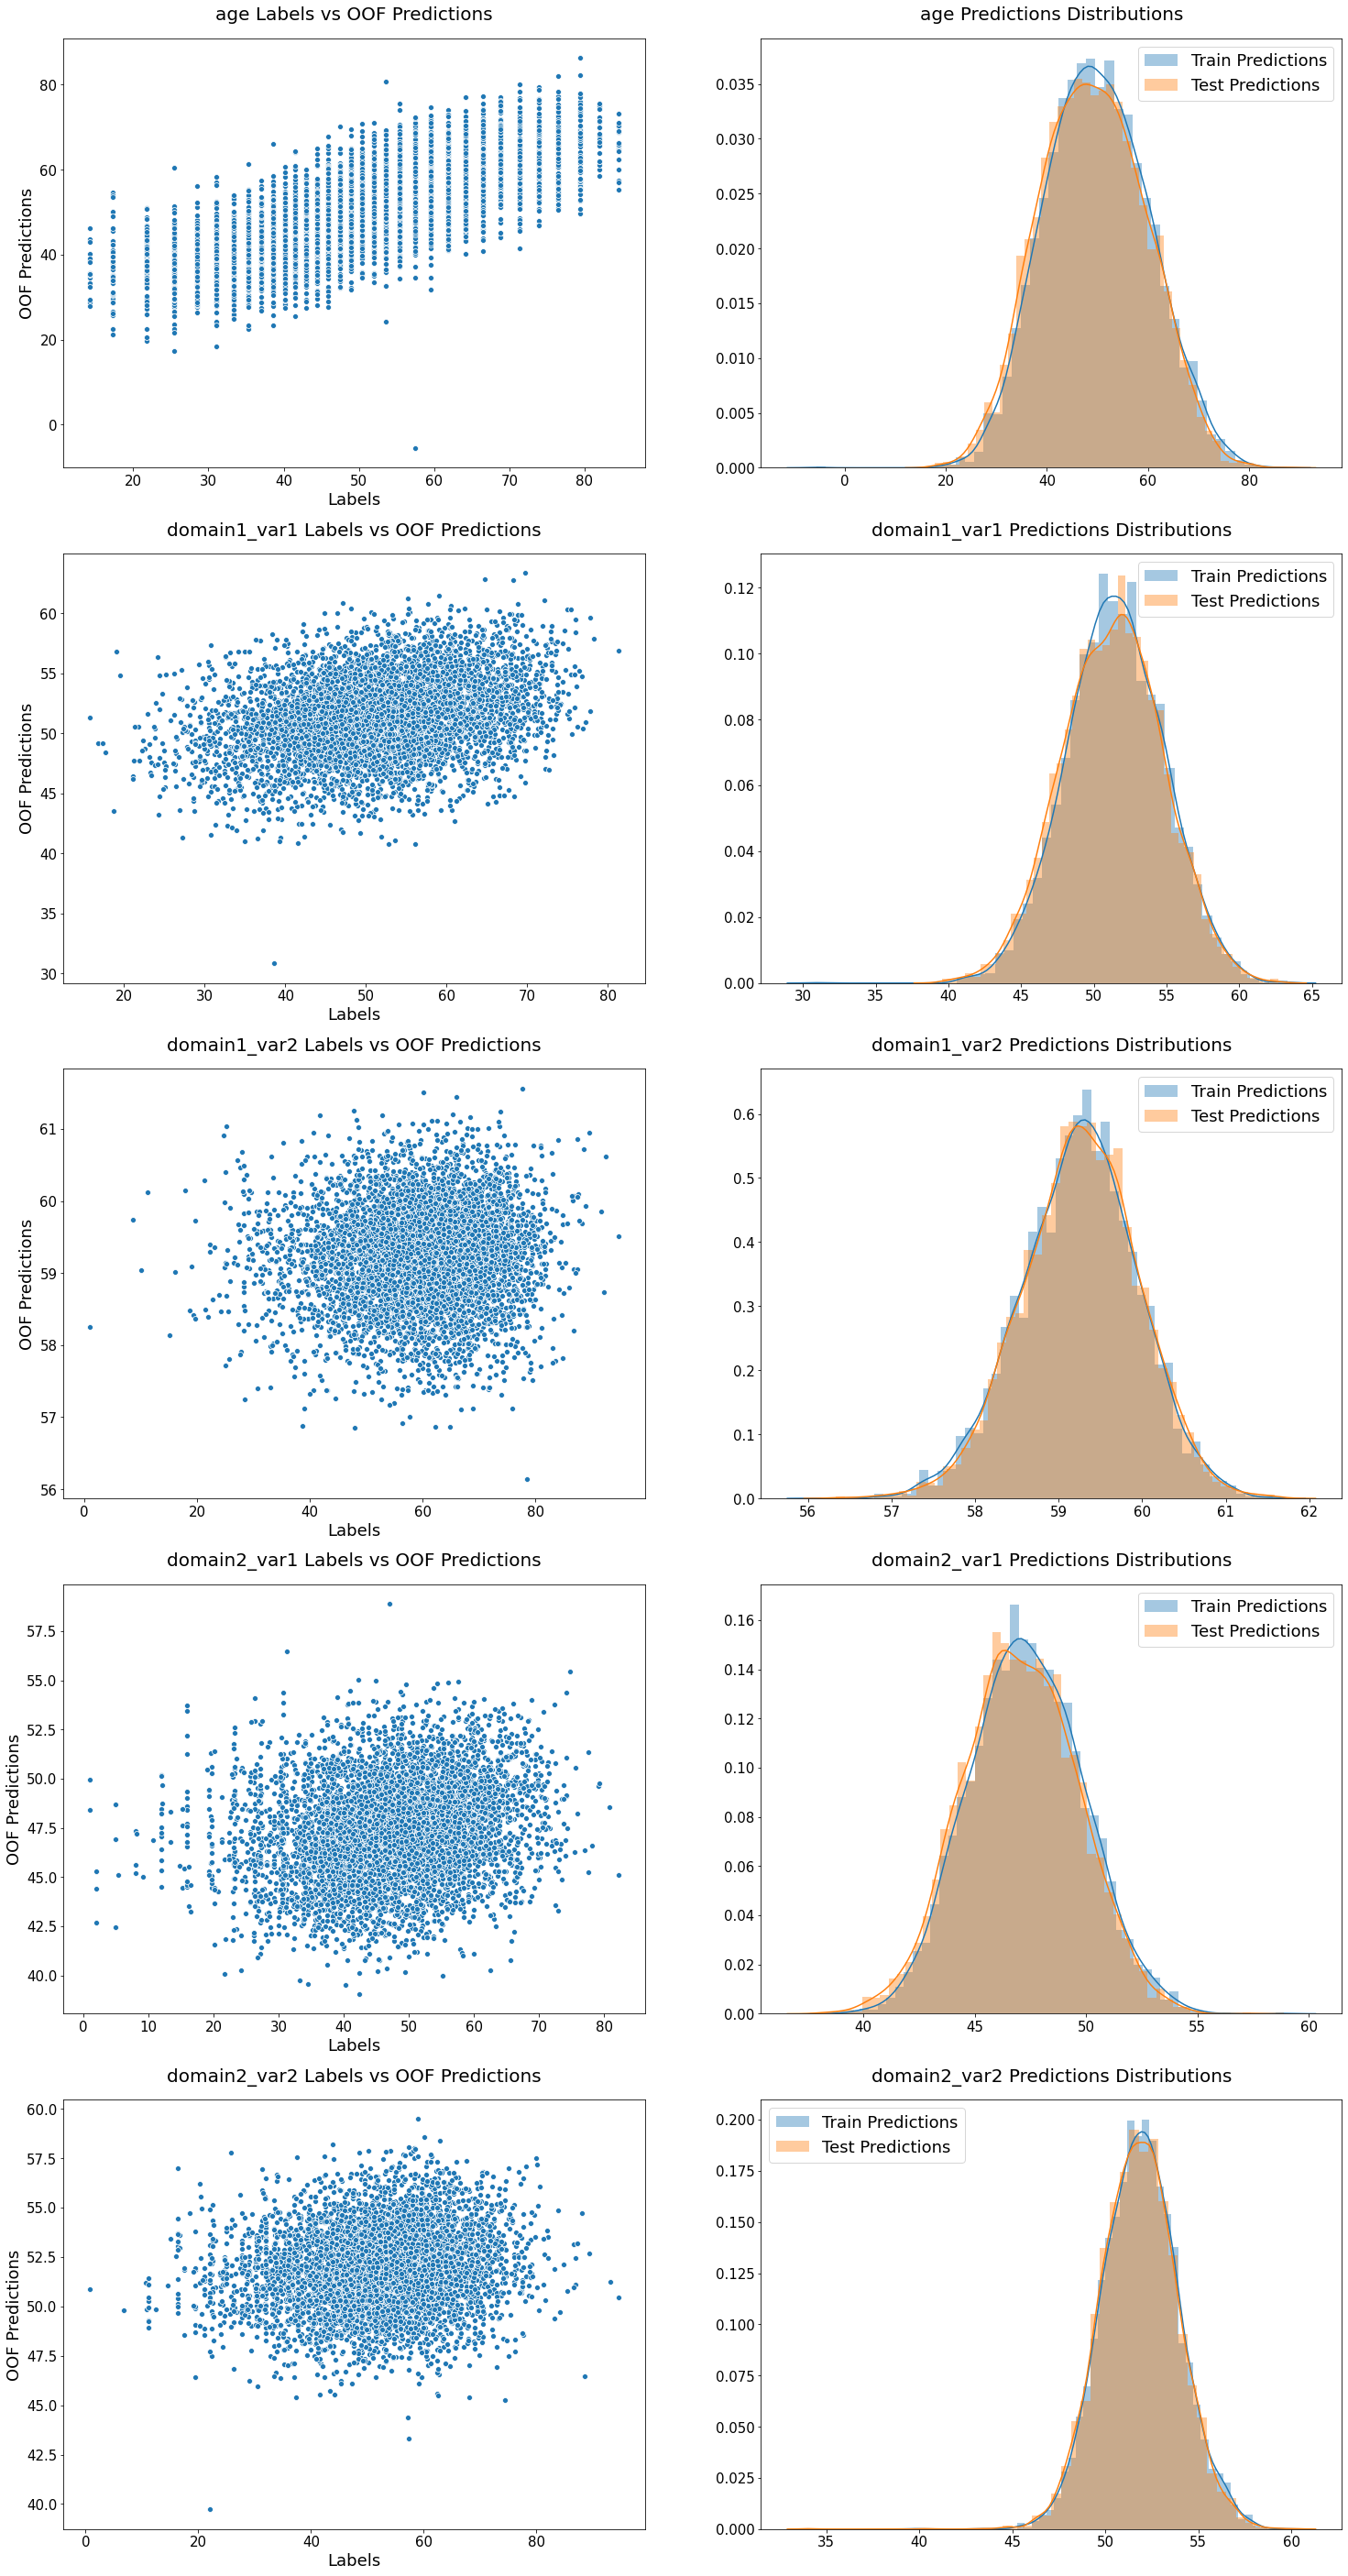

In [6]:
X_train = df_train[(loading_features + spatial_features)].copy(deep=True)
y_train = df_train[target_features].copy(deep=True)
X_test = df_test[(loading_features + spatial_features)].copy(deep=True)

for df in [X_train, X_test]:
    df[statistical_features] /= 5000
    df[boundingbox_features] /= 5000
    
np.random.seed(SEED)
y_train['age'] += np.random.normal(loc=0, scale=0.1, size=len(y_train))
    
model_features = {
    'age': loading_features + statistical_features + boundingbox_features,
    'domain1_var1': loading_features + statistical_features,
    'domain1_var2': loading_features + statistical_features,
    'domain2_var1': loading_features + statistical_features,
    'domain2_var2': loading_features + statistical_features
}

model_parameters = {
    'age': {
        'alpha': 0.0002
    },
    'domain1_var1': {
        'alpha': 0.0004
    },
    'domain1_var2': {
        'alpha': 0.05
    },
    'domain2_var1': {
        'alpha': 0.00075
    },
    'domain2_var2': {
        'alpha': 0.001
    }
}

linear_model_ensemble_parameters = {
    'model': 'RidgeRegression',
    'model_name': 'ridge_regression_loading',
    'model_features': model_features,
    'model_parameters': model_parameters,
    'cv': KFold(n_splits=10, shuffle=True, random_state=SEED),
    'n_rounds': 5,
    'loading_fraction': 1,
    'fnc_fraction': 1,
    'statistical_fraction': 1,
    'boundingbox_fraction': 0.95,
    'verbose': False
}

linear_model_ensemble = LinearModelEnsemble(**linear_model_ensemble_parameters)
linear_model_ensemble.run(X_train, y_train, X_test)

del X_train, y_train, X_test, model_features, model_parameters, linear_model_ensemble_parameters, linear_model_ensemble

### **3.2 SVR**


########## Running SVR Model ##########
---------------------------------------

Round 1 - Seed 1337
-------------------
Dropped 0/24 Random Loading Features
Dropped 0/1378 Random FNC Features
Dropped 0/689 Random Statistical Features
Dropped 79/1590 Random Bounding Box Features
SVR (age) OOF NAE 0.144493
SVR (domain1_var1) OOF NAE 0.151705
SVR (domain1_var2) OOF NAE 0.150912
SVR (domain2_var1) OOF NAE 0.18202
SVR (domain2_var2) OOF NAE 0.176378
----------------------------------------------------
SVR Global Weighted NAE 0.159026

Round 2 - Seed 5041992
----------------------
Dropped 0/24 Random Loading Features
Dropped 0/1378 Random FNC Features
Dropped 0/689 Random Statistical Features
Dropped 79/1590 Random Bounding Box Features
SVR (age) OOF NAE 0.144675
SVR (domain1_var1) OOF NAE 0.151748
SVR (domain1_var2) OOF NAE 0.150935
SVR (domain2_var1) OOF NAE 0.181975
SVR (domain2_var2) OOF NAE 0.176654
----------------------------------------------------
SVR Global Weighted NAE 0.159132


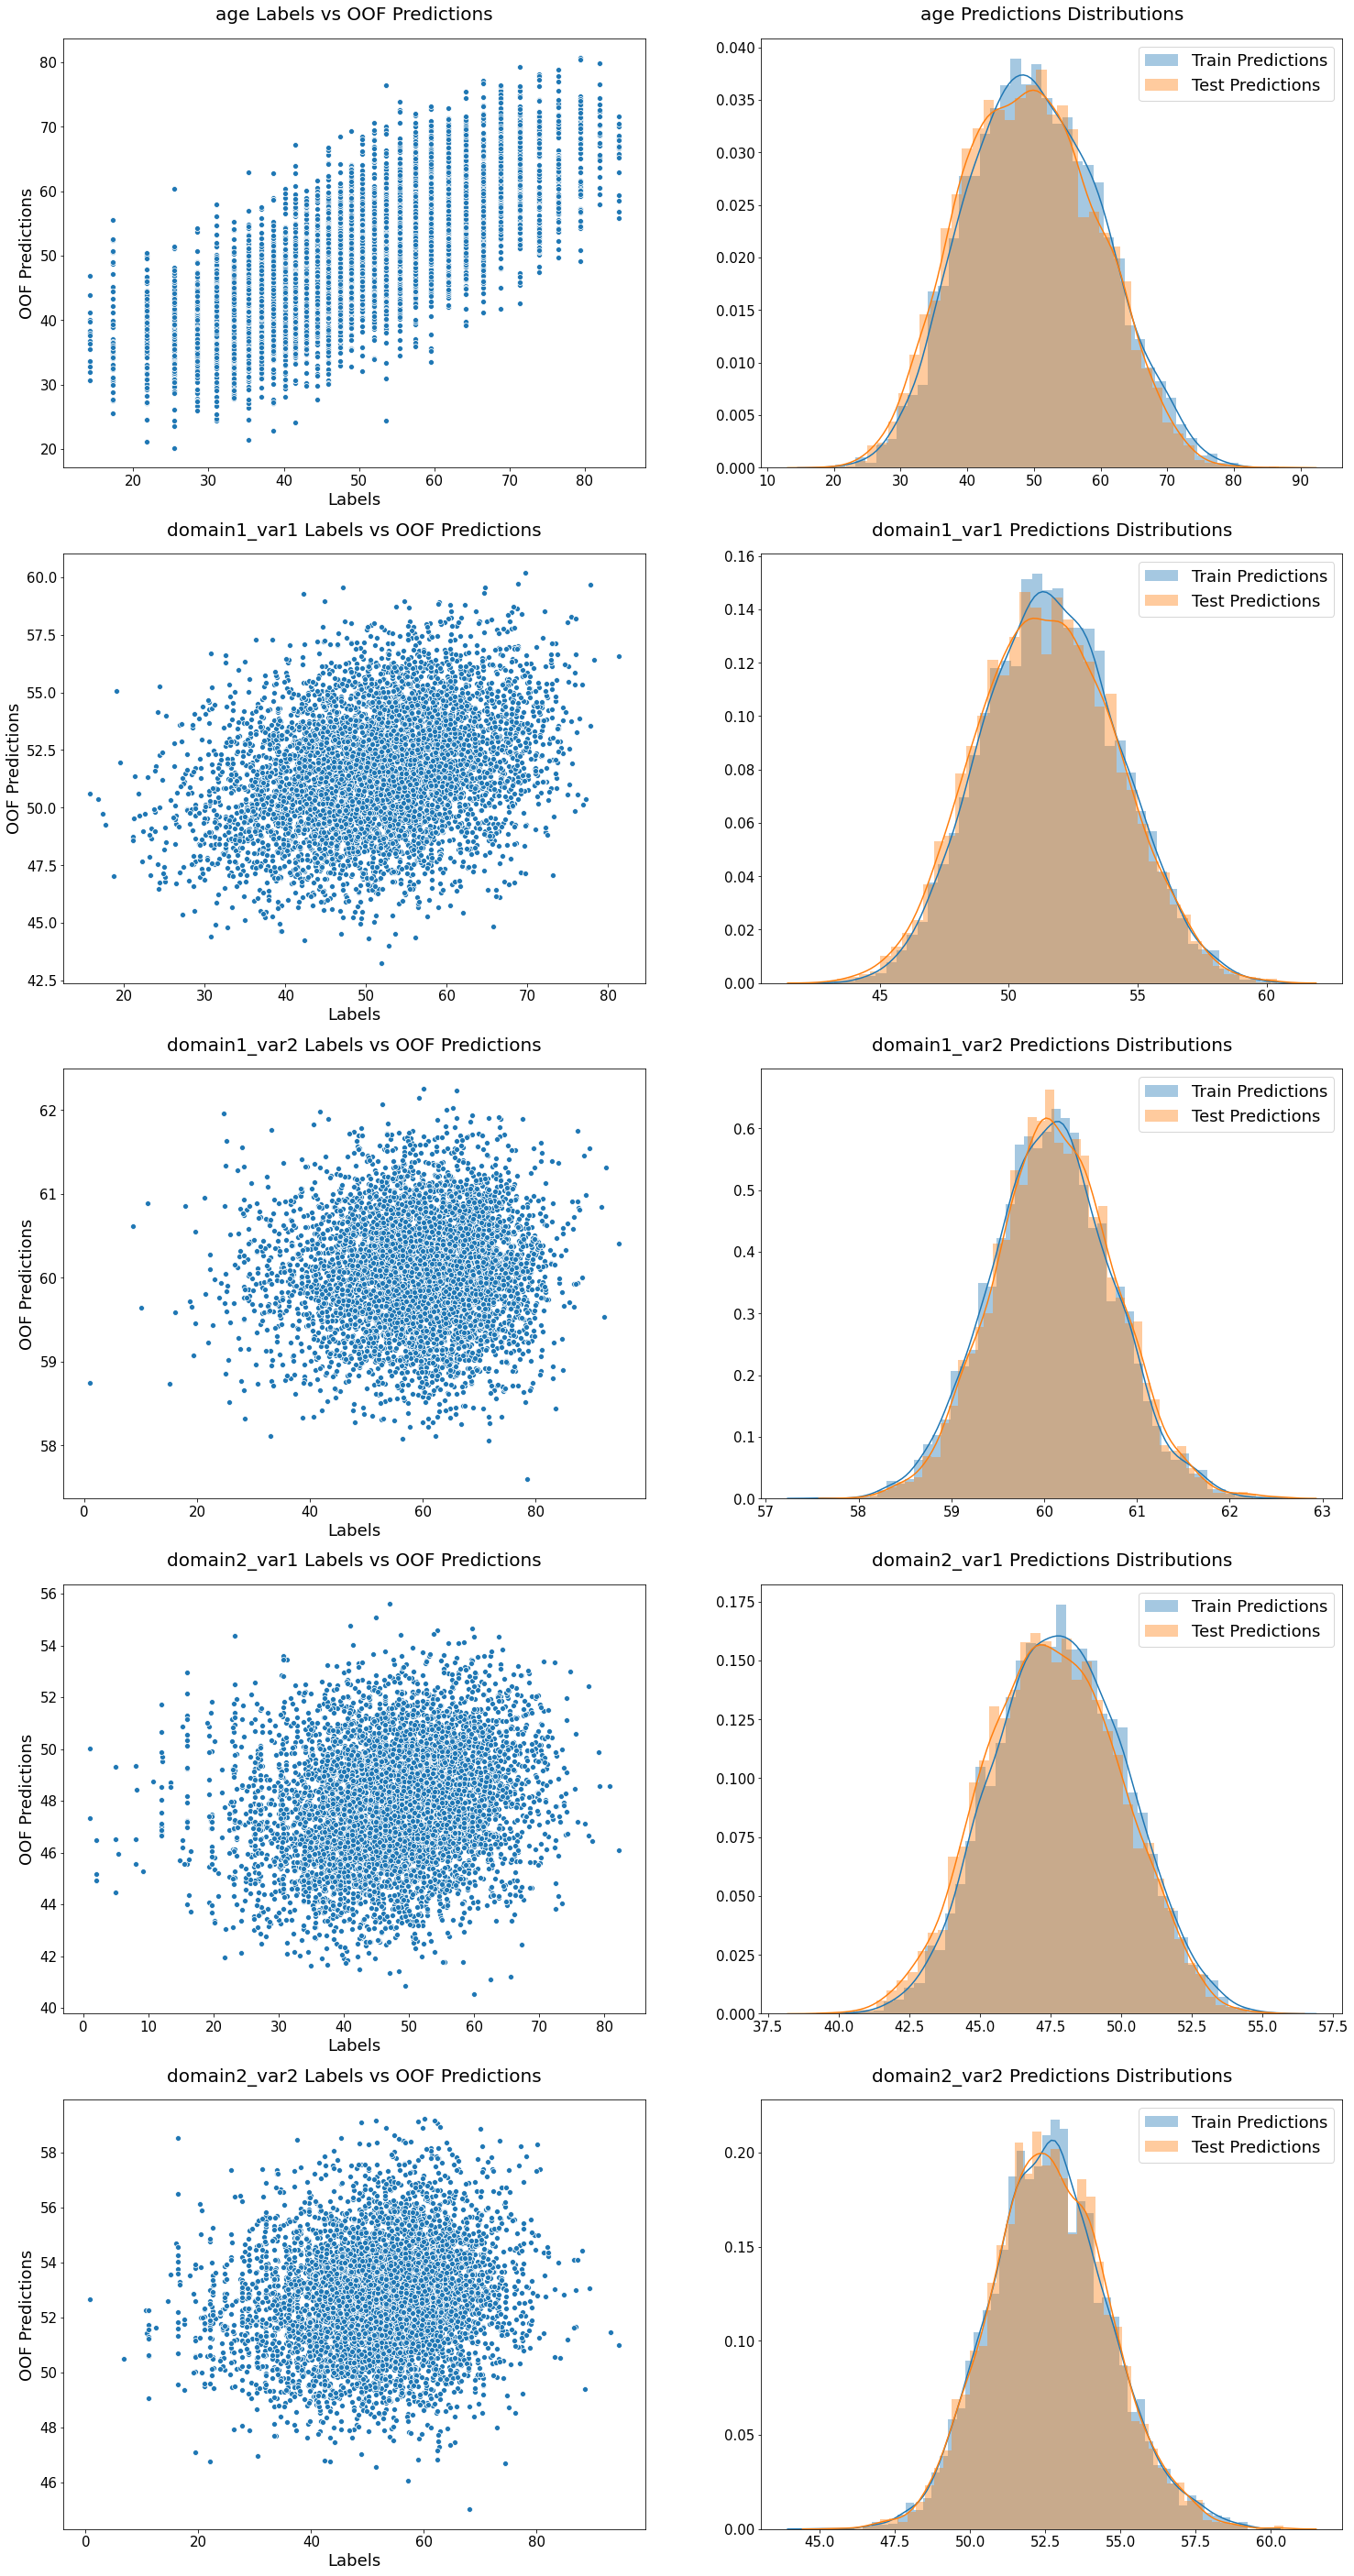

In [7]:
X_train = df_train[(loading_features + spatial_features)].copy(deep=True)
y_train = df_train[target_features].copy(deep=True)
X_test = df_test[(loading_features + spatial_features)].copy(deep=True)

for df in [X_train, X_test]:
    df[statistical_features] /= 5000
    df[boundingbox_features] /= 5000
    
np.random.seed(SEED)
y_train['age'] += np.random.normal(loc=0, scale=0.1, size=len(y_train))
    
model_features = {
    'age': loading_features + statistical_features + boundingbox_features,
    'domain1_var1': loading_features + statistical_features,
    'domain1_var2': loading_features + statistical_features,
    'domain2_var1': loading_features + statistical_features,
    'domain2_var2': loading_features + statistical_features
}

model_parameters = {
    'age': {
        'C': 100,
        'kernel': 'rbf',
        'cache_size': 3000
    },
    'domain1_var1': {
        'C': 2,
        'kernel': 'rbf',
        'cache_size': 3000
    },
    'domain1_var2': {
        'C': 1,
        'kernel': 'rbf',
        'cache_size': 3000
    },
    'domain2_var1': {
        'C': 3,
        'kernel': 'rbf',
        'cache_size': 3000
    },
    'domain2_var2': {
        'C': 9,
        'kernel': 'rbf',
        'cache_size': 3000
    }
}

linear_model_ensemble_parameters = {
    'model': 'SVR',
    'model_name': 'svr_loading',
    'model_features': model_features,
    'model_parameters': model_parameters,
    'cv': KFold(n_splits=10, shuffle=True, random_state=None),
    'n_rounds': 5,
    'loading_fraction': 1,
    'fnc_fraction': 1,
    'statistical_fraction': 1,
    'boundingbox_fraction': 0.95,
    'verbose': False
}

linear_model_ensemble = LinearModelEnsemble(**linear_model_ensemble_parameters)
linear_model_ensemble.run(X_train, y_train, X_test)

del X_train, y_train, X_test, model_features, model_parameters, linear_model_ensemble_parameters, linear_model_ensemble

## **4. Models Trained with FNC Features**

Models trained with FNC features are the main models of the ensemble. They make 99% of `domain1_var1`, `domain1_var2`, `domain2_var1` and `domain2_var2` predictions, and all of `age` predictions.

FNC features are scaled by 500, statistical features and bounding box features are scaled by 5000, and ±0.1 random noise added to `age` for increasing cardinality. 10 split regular `KFold` with shuffle is used as the cross-validation technique. 

### **4.1 Ridge Regression**


########## Running Ridge Regression Model ##########
----------------------------------------------------

Round 1 - Seed 1337
-------------------
Dropped 0/24 Random Loading Features
Dropped 68/1378 Random FNC Features
Dropped 0/689 Random Statistical Features
Dropped 0/1590 Random Bounding Box Features
Ridge Regression (age) OOF NAE 0.139074
Ridge Regression (domain1_var1) OOF NAE 0.150486
Ridge Regression (domain1_var2) OOF NAE 0.151085
Ridge Regression (domain2_var1) OOF NAE 0.181401
Ridge Regression (domain2_var2) OOF NAE 0.175756
----------------------------------------------------
Ridge Regression Global Weighted NAE 0.157

Round 2 - Seed 5041992
----------------------
Dropped 0/24 Random Loading Features
Dropped 68/1378 Random FNC Features
Dropped 0/689 Random Statistical Features
Dropped 0/1590 Random Bounding Box Features
Ridge Regression (age) OOF NAE 0.139078
Ridge Regression (domain1_var1) OOF NAE 0.150517
Ridge Regression (domain1_var2) OOF NAE 0.151033
Ridge Regression 

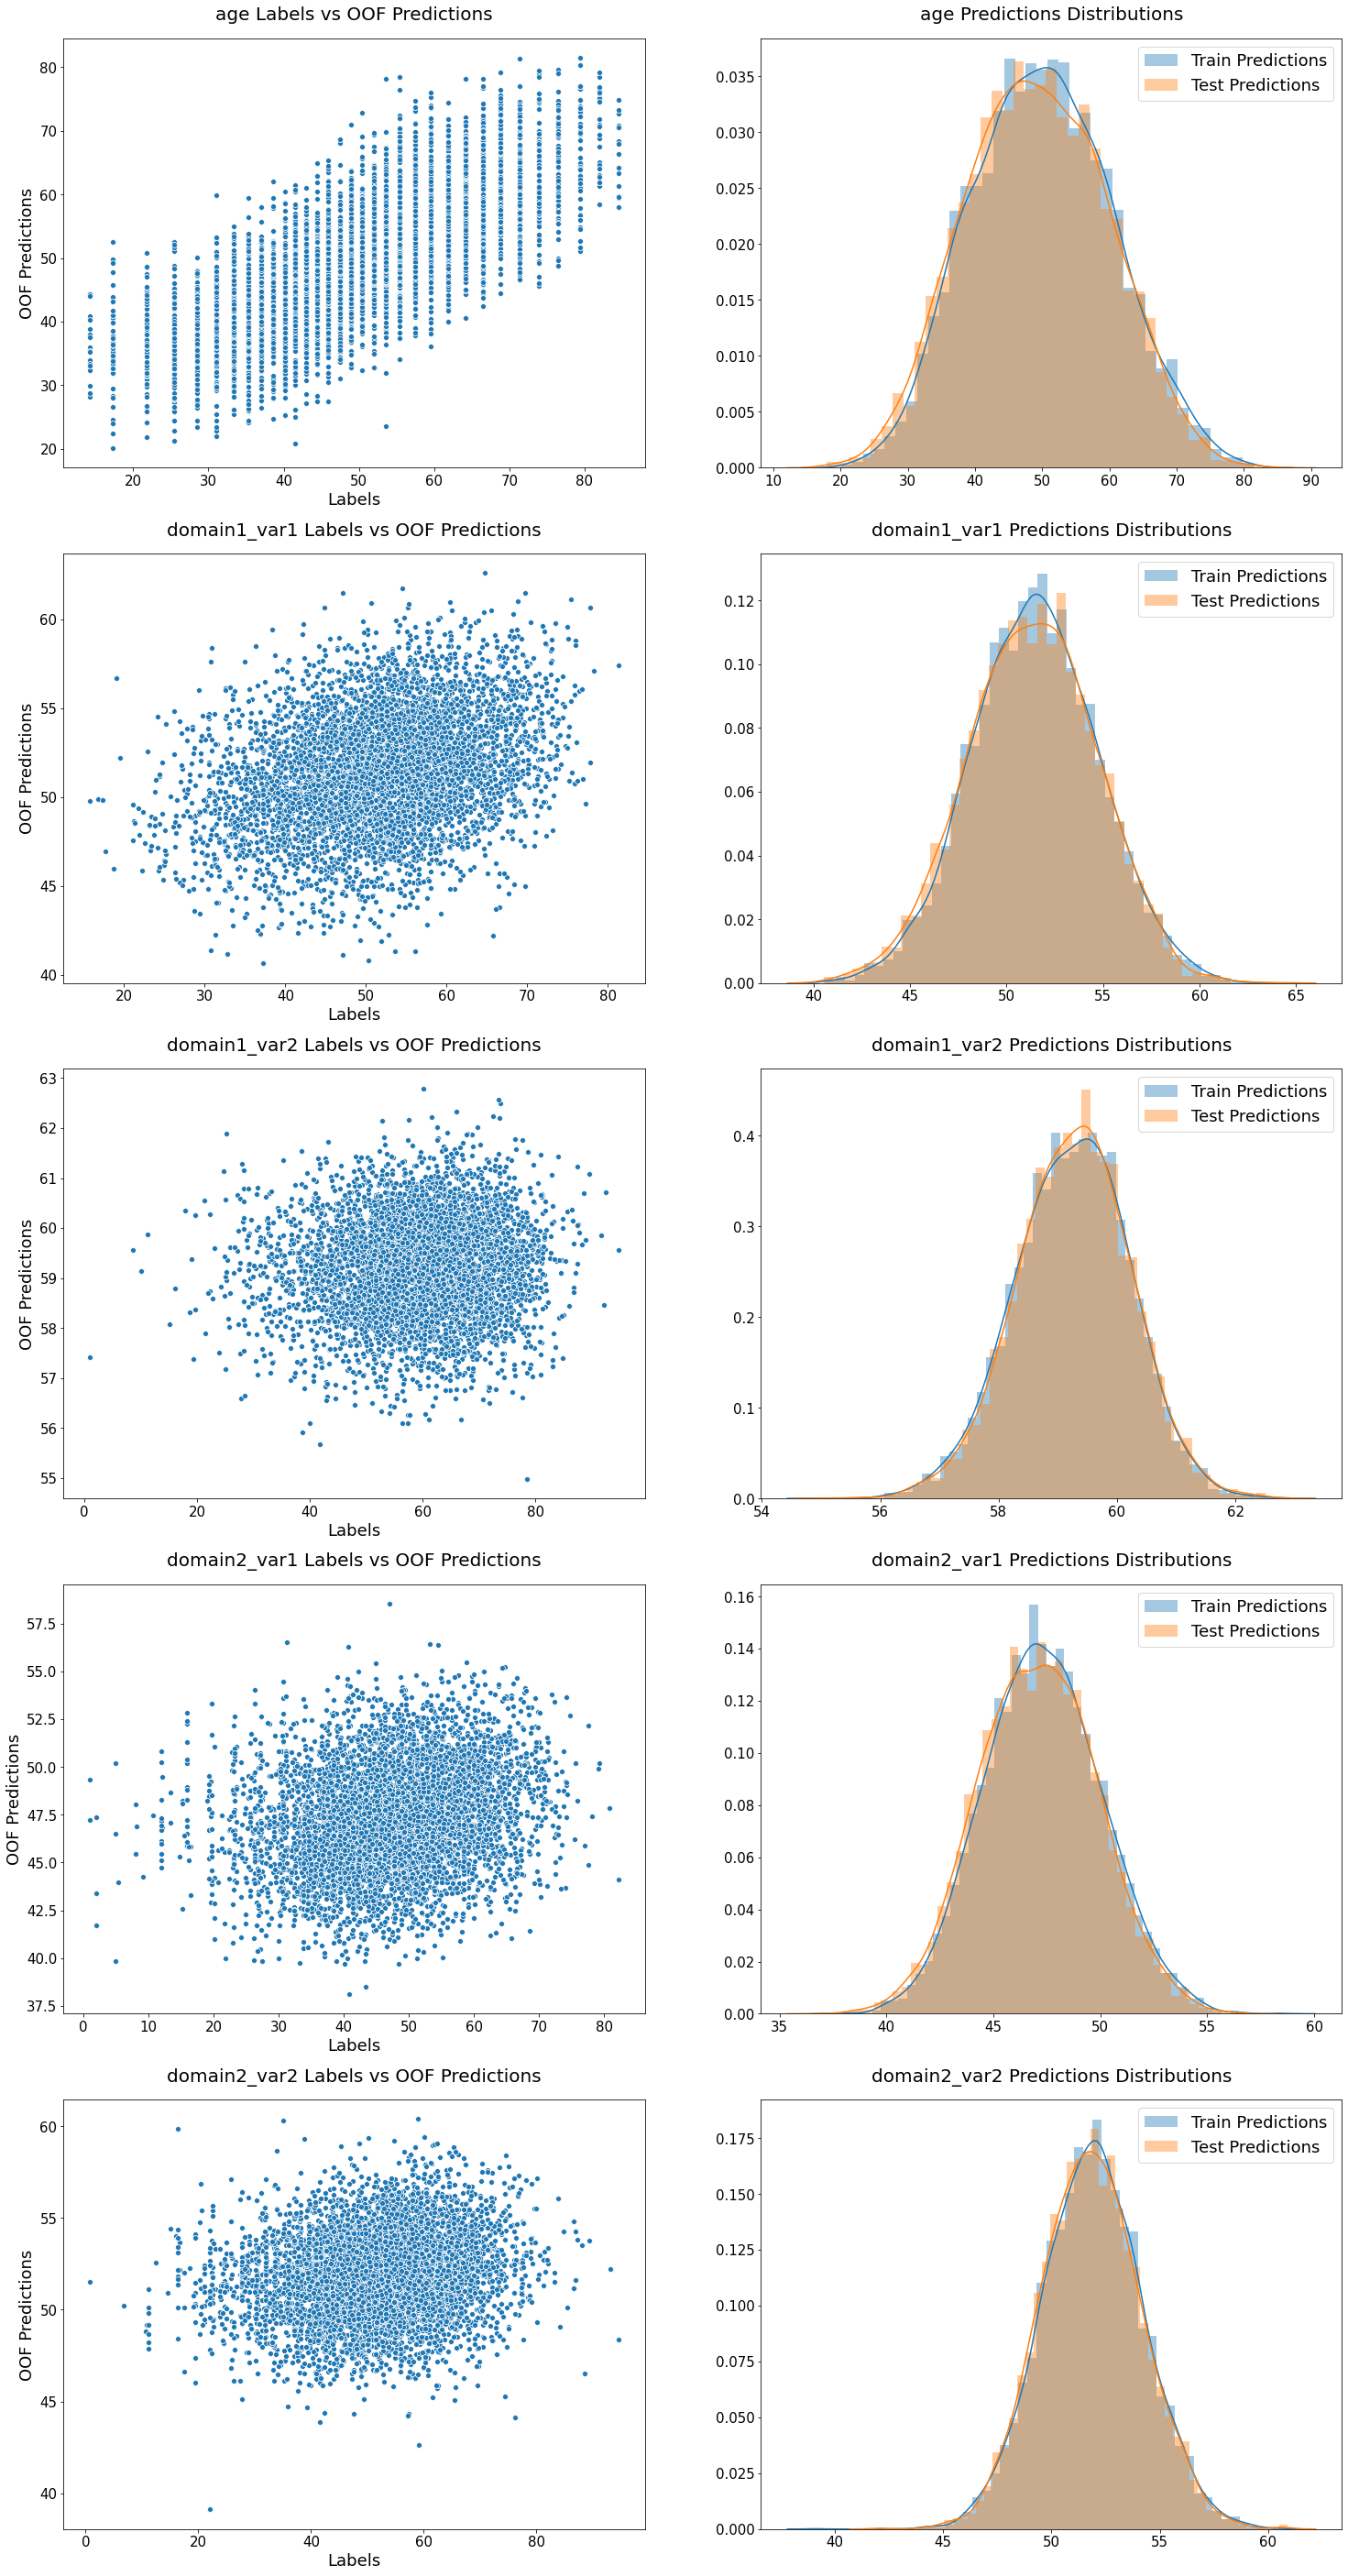

In [8]:
X_train = df_train[(loading_features + fnc_features + spatial_features)].copy(deep=True)
y_train = df_train[target_features].copy(deep=True)
X_test = df_test[(loading_features + fnc_features + spatial_features)].copy(deep=True)

for df in [X_train, X_test]:
    df[fnc_features] /= 500
    df[statistical_features] /= 5000
    df[boundingbox_features] /= 5000

np.random.seed(SEED)
y_train['age'] += np.random.normal(loc=0, scale=0.1, size=len(y_train))
    
model_features = {
    'age': loading_features + fnc_features + statistical_features + boundingbox_features,
    'domain1_var1': loading_features + fnc_features + statistical_features,
    'domain1_var2': loading_features + fnc_features + statistical_features,
    'domain2_var1': loading_features + fnc_features + statistical_features,
    'domain2_var2': loading_features + fnc_features + statistical_features 
}

model_parameters = {
    'age': {
        'alpha': 0.0004
    },
    'domain1_var1': {
        'alpha': 0.004
    },
    'domain1_var2': {
        'alpha': 0.02
    },
    'domain2_var1': {
        'alpha': 0.002
    },
    'domain2_var2': {
        'alpha': 0.003
    }
}

linear_model_ensemble_parameters = {
    'model': 'RidgeRegression',
    'model_name': 'ridge_regression_all',
    'model_features': model_features,
    'model_parameters': model_parameters,
    'cv': KFold(n_splits=10, shuffle=True, random_state=SEED),
    'n_rounds': 5,
    'loading_fraction': 1,
    'fnc_fraction': 0.95,
    'statistical_fraction': 1,
    'boundingbox_fraction': 1,
    'verbose': False
}

linear_model_ensemble = LinearModelEnsemble(**linear_model_ensemble_parameters)
linear_model_ensemble.run(X_train, y_train, X_test)

del X_train, y_train, X_test, model_features, model_parameters, linear_model_ensemble_parameters, linear_model_ensemble

### **4.2 SVR**


########## Running SVR Model ##########
---------------------------------------

Round 1 - Seed 1337
-------------------
Dropped 0/24 Random Loading Features
Dropped 0/1378 Random FNC Features
Dropped 0/689 Random Statistical Features
Dropped 0/1590 Random Bounding Box Features
SVR (age) OOF NAE 0.140174
SVR (domain1_var1) OOF NAE 0.151099
SVR (domain1_var2) OOF NAE 0.150832
SVR (domain2_var1) OOF NAE 0.181619
SVR (domain2_var2) OOF NAE 0.175278
----------------------------------------------------
SVR Global Weighted NAE 0.157347

Round 2 - Seed 5041992
----------------------
Dropped 0/24 Random Loading Features
Dropped 0/1378 Random FNC Features
Dropped 0/689 Random Statistical Features
Dropped 0/1590 Random Bounding Box Features
SVR (age) OOF NAE 0.140241
SVR (domain1_var1) OOF NAE 0.151062
SVR (domain1_var2) OOF NAE 0.150832
SVR (domain2_var1) OOF NAE 0.181344
SVR (domain2_var2) OOF NAE 0.175533
----------------------------------------------------
SVR Global Weighted NAE 0.157357



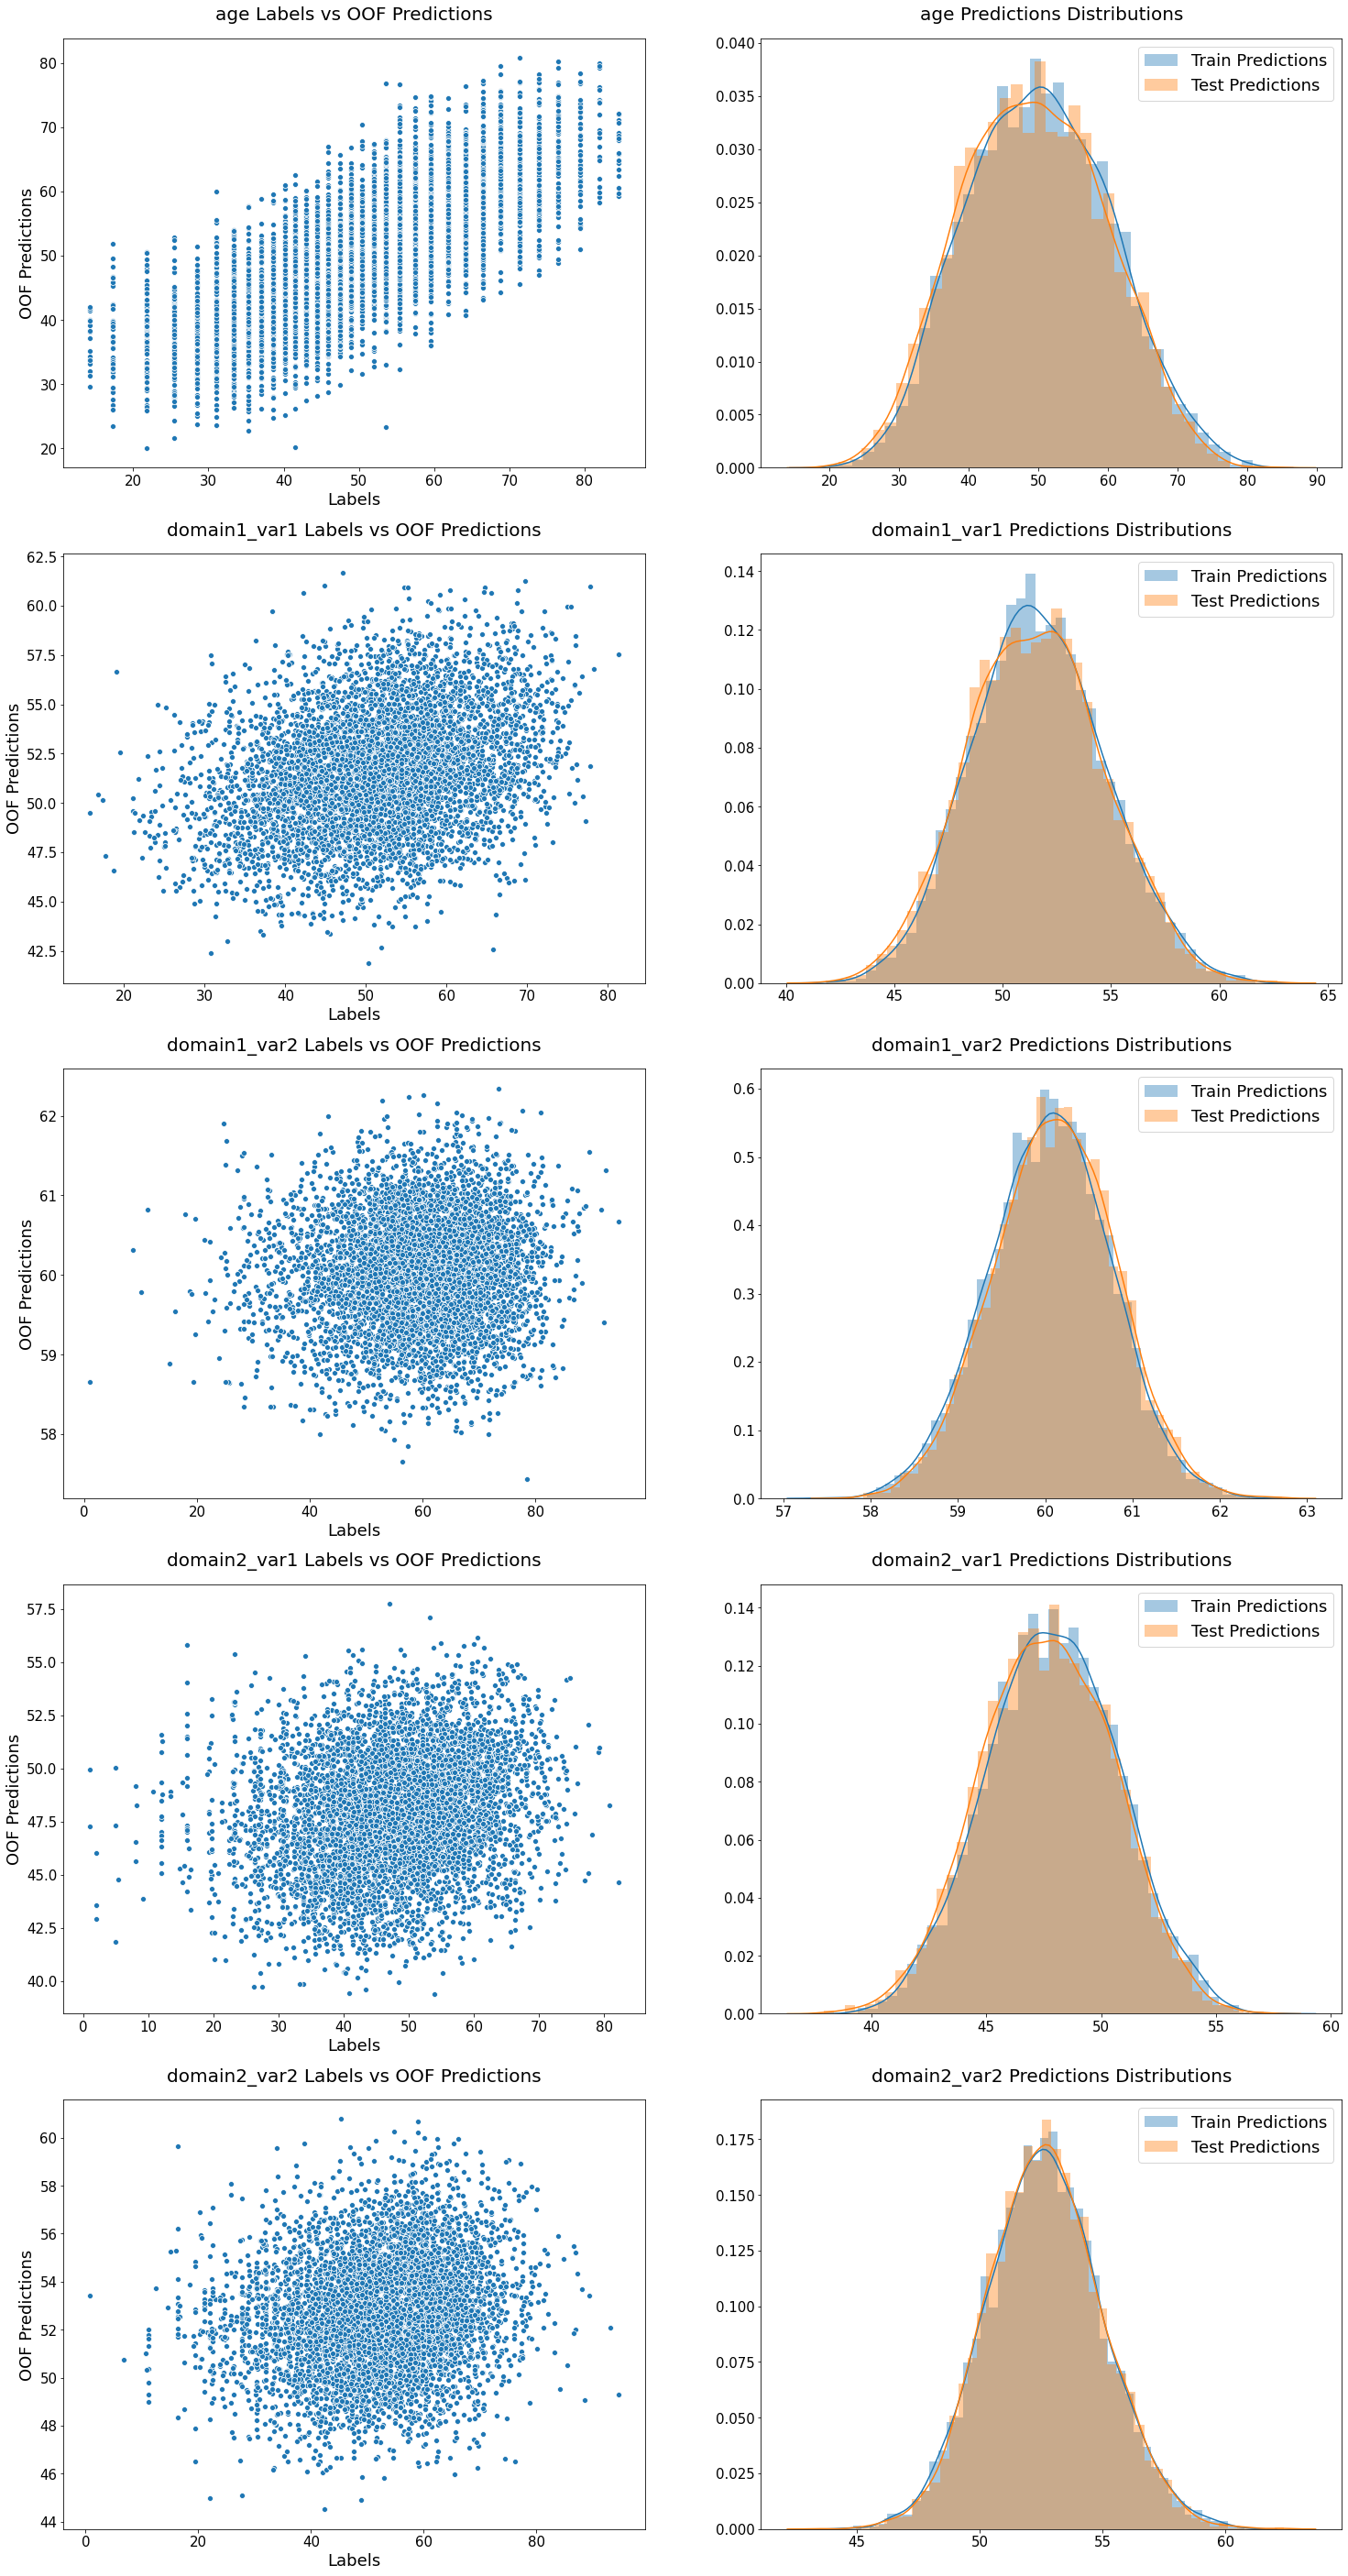

In [9]:
X_train = df_train[(loading_features + fnc_features + spatial_features)].copy(deep=True)
y_train = df_train[target_features].copy(deep=True)
X_test = df_test[(loading_features + fnc_features + spatial_features)].copy(deep=True)

for df in [X_train, X_test]:
    df[fnc_features] /= 500
    df[statistical_features] /= 5000
    df[boundingbox_features] /= 5000   
    
np.random.seed(SEED)
y_train['age'] += np.random.normal(loc=0, scale=0.1, size=len(y_train))
    
model_features = {
    'age': loading_features + fnc_features + statistical_features + boundingbox_features,
    'domain1_var1': loading_features + fnc_features + statistical_features,
    'domain1_var2': loading_features + fnc_features + statistical_features,
    'domain2_var1': loading_features + fnc_features + statistical_features,
    'domain2_var2': loading_features + fnc_features + statistical_features
}

model_parameters = {
    'age': {
        'C': 72,
        'kernel': 'rbf',
        'cache_size': 3000
    },
    'domain1_var1': {
        'C': 7,
        'kernel': 'rbf',
        'cache_size': 3000
    },
    'domain1_var2': {
        'C': 1,
        'kernel': 'rbf',
        'cache_size': 3000
    },
    'domain2_var1': {
        'C': 10,
        'kernel': 'rbf',
        'cache_size': 3000
    },
    'domain2_var2': {
        'C': 10,
        'kernel': 'rbf',
        'cache_size': 3000
    }
}

linear_model_ensemble_parameters = {
    'model': 'SVR',
    'model_name': 'svr_all',
    'model_features': model_features,
    'model_parameters': model_parameters,
    'cv': KFold(n_splits=10, shuffle=True, random_state=SEED),
    'n_rounds': 5,
    'loading_fraction': 1,
    'fnc_fraction': 1,
    'statistical_fraction': 1,
    'boundingbox_fraction': 1,
    'verbose': False
}

linear_model_ensemble = LinearModelEnsemble(**linear_model_ensemble_parameters)
linear_model_ensemble.run(X_train, y_train, X_test)

del X_train, y_train, X_test, model_features, model_parameters, linear_model_ensemble_parameters

## **5. Evaluation and Blending**

There are 2 (2 times `n_rounds`) models used in blend of `age`, and those models are `Ridge` and `SVR` trained with FNC features. Those models' predictions are blended equally (0.5 + 0.5).

There are 4 (4 times `n_rounds`) models used in blends of other targets, and those models are `Ridge` and `SVR` trained with and without FNC features. Models trained without FNC are blended equally (0.05 + 0.05) which makes up to 1%, and models trained with FNC are also blended equally (0.495 + 0.495) which makes up 99%.

In [10]:
def normalized_absolute_error(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred)) / np.sum(y_true))

target_weights = np.array([0.3, 0.175, 0.175, 0.175, 0.175])
ridge_loading_scores = []
svr_loading_scores = []
ridge_all_scores = []
svr_all_scores = []
blend_scores = []

print('---------- age ----------\n')

age_labels = df_train[~df_train['age'].isnull()]['age']

ridge_loading_age_oof_score = normalized_absolute_error(age_labels, df_train.loc[~df_train['age'].isnull()]['ridge_regression_loading_age'])
svr_loading_age_oof_score = normalized_absolute_error(age_labels, df_train.loc[~df_train['age'].isnull()]['svr_loading_age'])
ridge_all_age_oof_score = normalized_absolute_error(age_labels, df_train.loc[~df_train['age'].isnull()]['ridge_regression_all_age'])
svr_all_age_oof_score = normalized_absolute_error(age_labels, df_train.loc[~df_train['age'].isnull()]['svr_all_age'])

df_train.loc[~df_train['age'].isnull(), 'blend_age'] = (df_train.loc[~df_train['age'].isnull(), 'ridge_regression_loading_age'] * 0) +\
                                                       (df_train.loc[~df_train['age'].isnull(), 'svr_loading_age'] * 0) +\
                                                       (df_train.loc[~df_train['age'].isnull(), 'ridge_regression_all_age'] * 0.5) +\
                                                       (df_train.loc[~df_train['age'].isnull(), 'svr_all_age'] * 0.5)

df_test['blend_age'] = (df_test['ridge_regression_loading_age'] * 0) +\
                       (df_test['svr_loading_age'] * 0) +\
                       (df_test['ridge_regression_all_age'] * 0.5) +\
                       (df_test['svr_all_age'] * 0.5)          

blend_age_oof_score = normalized_absolute_error(age_labels, df_train[~df_train['age'].isnull()]['blend_age'])

ridge_loading_scores.append(ridge_loading_age_oof_score)
svr_loading_scores.append(svr_loading_age_oof_score)
ridge_all_scores.append(ridge_all_age_oof_score)
svr_all_scores.append(svr_all_age_oof_score)
blend_scores.append(blend_age_oof_score)

print(f'Ridge Regression Loading (age) OOF NAE {ridge_loading_age_oof_score:.6}')
print(f'SVR Loading (age) OOF NAE {svr_loading_age_oof_score:.6}')
print(f'Ridge Regression All (age) OOF NAE {ridge_all_age_oof_score:.6}')
print(f'SVR (age) All OOF NAE {svr_all_age_oof_score:.6}')
print(f'Blend (age) OOF NAE {blend_age_oof_score:.6}')

print('\n---------- domain1_var1 ----------\n')

domain1_var1_labels = df_train[~df_train['domain1_var1'].isnull()]['domain1_var1']

ridge_loading_domain1_var1_oof_score = normalized_absolute_error(domain1_var1_labels, df_train.loc[~df_train['domain1_var1'].isnull()]['ridge_regression_loading_domain1_var1'])
svr_loading_domain1_var1_oof_score = normalized_absolute_error(domain1_var1_labels, df_train.loc[~df_train['domain1_var1'].isnull()]['svr_loading_domain1_var1'])
ridge_all_domain1_var1_oof_score = normalized_absolute_error(domain1_var1_labels, df_train.loc[~df_train['domain1_var1'].isnull()]['ridge_regression_all_domain1_var1'])
svr_all_domain1_var1_oof_score = normalized_absolute_error(domain1_var1_labels, df_train.loc[~df_train['domain1_var1'].isnull()]['svr_all_domain1_var1'])

df_train.loc[~df_train['domain1_var1'].isnull(), 'blend_domain1_var1'] = (df_train.loc[~df_train['domain1_var1'].isnull(), 'ridge_regression_loading_domain1_var1'] * 0.005) +\
                                                                         (df_train.loc[~df_train['domain1_var1'].isnull(), 'svr_loading_domain1_var1'] * 0.005) +\
                                                                         (df_train.loc[~df_train['domain1_var1'].isnull(), 'ridge_regression_all_domain1_var1'] * 0.495) +\
                                                                         (df_train.loc[~df_train['domain1_var1'].isnull(), 'svr_all_domain1_var1'] * 0.495)

df_test['blend_domain1_var1'] = (df_test['ridge_regression_loading_domain1_var1'] * 0.005) +\
                                (df_test['svr_loading_domain1_var1'] * 0.005) +\
                                (df_test['ridge_regression_all_domain1_var1'] * 0.495) +\
                                (df_test['svr_all_domain1_var1'] * 0.495)          

blend_domain1_var1_oof_score = normalized_absolute_error(domain1_var1_labels, df_train[~df_train['domain1_var1'].isnull()]['blend_domain1_var1'])

ridge_loading_scores.append(ridge_loading_domain1_var1_oof_score)
svr_loading_scores.append(svr_loading_domain1_var1_oof_score)
ridge_all_scores.append(ridge_all_domain1_var1_oof_score)
svr_all_scores.append(svr_all_domain1_var1_oof_score)
blend_scores.append(blend_domain1_var1_oof_score)

print(f'Ridge Regression Loading (domain1_var1) OOF NAE {ridge_loading_domain1_var1_oof_score:.6}')
print(f'SVR Loading (domain1_var1) OOF NAE {svr_loading_domain1_var1_oof_score:.6}')
print(f'Ridge Regression All (domain1_var1) OOF NAE {ridge_all_domain1_var1_oof_score:.6}')
print(f'SVR (domain1_var1) All OOF NAE {svr_all_domain1_var1_oof_score:.6}')
print(f'Blend (domain1_var1) OOF NAE {blend_domain1_var1_oof_score:.6}')

print('\n---------- domain1_var2 ----------\n')

domain1_var2_labels = df_train[~df_train['domain1_var2'].isnull()]['domain1_var2']

ridge_loading_domain1_var2_oof_score = normalized_absolute_error(domain1_var2_labels, df_train.loc[~df_train['domain1_var2'].isnull()]['ridge_regression_loading_domain1_var2'])
svr_loading_domain1_var2_oof_score = normalized_absolute_error(domain1_var2_labels, df_train.loc[~df_train['domain1_var2'].isnull()]['svr_loading_domain1_var2'])
ridge_all_domain1_var2_oof_score = normalized_absolute_error(domain1_var2_labels, df_train.loc[~df_train['domain1_var2'].isnull()]['ridge_regression_all_domain1_var2'])
svr_all_domain1_var2_oof_score = normalized_absolute_error(domain1_var2_labels, df_train.loc[~df_train['domain1_var2'].isnull()]['svr_all_domain1_var2'])

df_train.loc[~df_train['domain1_var2'].isnull(), 'blend_domain1_var2'] = (df_train.loc[~df_train['domain1_var2'].isnull(), 'ridge_regression_loading_domain1_var2'] * 0.005) +\
                                                                         (df_train.loc[~df_train['domain1_var2'].isnull(), 'svr_loading_domain1_var2'] * 0.005) +\
                                                                         (df_train.loc[~df_train['domain1_var2'].isnull(), 'ridge_regression_all_domain1_var2'] * 0.495) +\
                                                                         (df_train.loc[~df_train['domain1_var2'].isnull(), 'svr_all_domain1_var2'] * 0.495)

df_test['blend_domain1_var2'] = (df_test['ridge_regression_loading_domain1_var2'] * 0.005) +\
                                (df_test['svr_loading_domain1_var2'] * 0.005) +\
                                (df_test['ridge_regression_all_domain1_var2'] * 0.495) +\
                                (df_test['svr_all_domain1_var2'] * 0.495)          

blend_domain1_var2_oof_score = normalized_absolute_error(domain1_var2_labels, df_train[~df_train['domain1_var2'].isnull()]['blend_domain1_var2'])

ridge_loading_scores.append(ridge_loading_domain1_var2_oof_score)
svr_loading_scores.append(svr_loading_domain1_var2_oof_score)
ridge_all_scores.append(ridge_all_domain1_var2_oof_score)
svr_all_scores.append(svr_all_domain1_var2_oof_score)
blend_scores.append(blend_domain1_var2_oof_score)

print(f'Ridge Regression Loading (domain1_var2) OOF NAE {ridge_loading_domain1_var2_oof_score:.6}')
print(f'SVR Loading (domain1_var2) OOF NAE {svr_loading_domain1_var2_oof_score:.6}')
print(f'Ridge Regression All (domain1_var2) OOF NAE {ridge_all_domain1_var2_oof_score:.6}')
print(f'SVR (domain1_var2) All OOF NAE {svr_all_domain1_var2_oof_score:.6}')
print(f'Blend (domain1_var2) OOF NAE {blend_domain1_var2_oof_score:.6}')

print('\n---------- domain2_var1 ----------\n')

domain2_var1_labels = df_train[~df_train['domain2_var1'].isnull()]['domain2_var1']

ridge_loading_domain2_var1_oof_score = normalized_absolute_error(domain2_var1_labels, df_train.loc[~df_train['domain2_var1'].isnull()]['ridge_regression_loading_domain2_var1'])
svr_loading_domain2_var1_oof_score = normalized_absolute_error(domain2_var1_labels, df_train.loc[~df_train['domain2_var1'].isnull()]['svr_loading_domain2_var1'])
ridge_all_domain2_var1_oof_score = normalized_absolute_error(domain2_var1_labels, df_train.loc[~df_train['domain2_var1'].isnull()]['ridge_regression_all_domain2_var1'])
svr_all_domain2_var1_oof_score = normalized_absolute_error(domain2_var1_labels, df_train.loc[~df_train['domain2_var1'].isnull()]['svr_all_domain2_var1'])

df_train.loc[~df_train['domain2_var1'].isnull(), 'blend_domain2_var1'] = (df_train.loc[~df_train['domain2_var1'].isnull(), 'ridge_regression_loading_domain2_var1'] * 0.005) +\
                                                                         (df_train.loc[~df_train['domain2_var1'].isnull(), 'svr_loading_domain2_var1'] * 0.005) +\
                                                                         (df_train.loc[~df_train['domain2_var1'].isnull(), 'ridge_regression_all_domain2_var1'] * 0.495) +\
                                                                         (df_train.loc[~df_train['domain2_var1'].isnull(), 'svr_all_domain2_var1'] * 0.495)

df_test['blend_domain2_var1'] = (df_test['ridge_regression_loading_domain2_var1'] * 0.005) +\
                                (df_test['svr_loading_domain2_var1'] * 0.005) +\
                                (df_test['ridge_regression_all_domain2_var1'] * 0.495) +\
                                (df_test['svr_all_domain2_var1'] * 0.495)          

blend_domain2_var1_oof_score = normalized_absolute_error(domain2_var1_labels, df_train[~df_train['domain2_var1'].isnull()]['blend_domain2_var1'])

ridge_loading_scores.append(ridge_loading_domain2_var1_oof_score)
svr_loading_scores.append(svr_loading_domain2_var1_oof_score)
ridge_all_scores.append(ridge_all_domain2_var1_oof_score)
svr_all_scores.append(svr_all_domain2_var1_oof_score)
blend_scores.append(blend_domain2_var1_oof_score)

print(f'Ridge Regression Loading (domain2_var1) OOF NAE {ridge_loading_domain2_var1_oof_score:.6}')
print(f'SVR Loading (domain2_var1) OOF NAE {svr_loading_domain2_var1_oof_score:.6}')
print(f'Ridge Regression All (domain2_var1) OOF NAE {ridge_all_domain2_var1_oof_score:.6}')
print(f'SVR (domain2_var1) All OOF NAE {svr_all_domain2_var1_oof_score:.6}')
print(f'Blend (domain2_var1) OOF NAE {blend_domain2_var1_oof_score:.6}')

print('\n---------- domain2_var2 ----------\n')

domain2_var2_labels = df_train[~df_train['domain2_var2'].isnull()]['domain2_var2']

ridge_loading_domain2_var2_oof_score = normalized_absolute_error(domain2_var2_labels, df_train.loc[~df_train['domain2_var2'].isnull()]['ridge_regression_loading_domain2_var2'])
svr_loading_domain2_var2_oof_score = normalized_absolute_error(domain2_var2_labels, df_train.loc[~df_train['domain2_var2'].isnull()]['svr_loading_domain2_var2'])
ridge_all_domain2_var2_oof_score = normalized_absolute_error(domain2_var2_labels, df_train.loc[~df_train['domain2_var2'].isnull()]['ridge_regression_all_domain2_var2'])
svr_all_domain2_var2_oof_score = normalized_absolute_error(domain2_var2_labels, df_train.loc[~df_train['domain2_var2'].isnull()]['svr_all_domain2_var2'])

df_train.loc[~df_train['domain2_var2'].isnull(), 'blend_domain2_var2'] = (df_train.loc[~df_train['domain2_var2'].isnull(), 'ridge_regression_loading_domain2_var2'] * 0.005) +\
                                                                         (df_train.loc[~df_train['domain2_var2'].isnull(), 'svr_loading_domain2_var2'] * 0.005) +\
                                                                         (df_train.loc[~df_train['domain2_var2'].isnull(), 'ridge_regression_all_domain2_var2'] * 0.495) +\
                                                                         (df_train.loc[~df_train['domain2_var2'].isnull(), 'svr_all_domain2_var2'] * 0.495)

df_test['blend_domain2_var2'] = (df_test['ridge_regression_loading_domain2_var2'] * 0.005) +\
                                (df_test['svr_loading_domain2_var2'] * 0.005) +\
                                (df_test['ridge_regression_all_domain2_var2'] * 0.495) +\
                                (df_test['svr_all_domain2_var2'] * 0.495)          

blend_domain2_var2_oof_score = normalized_absolute_error(domain2_var2_labels, df_train[~df_train['domain2_var2'].isnull()]['blend_domain2_var2'])

ridge_loading_scores.append(ridge_loading_domain2_var2_oof_score)
svr_loading_scores.append(svr_loading_domain2_var2_oof_score)
ridge_all_scores.append(ridge_all_domain2_var2_oof_score)
svr_all_scores.append(svr_all_domain2_var2_oof_score)
blend_scores.append(blend_domain2_var2_oof_score)

print(f'Ridge Regression Loading (domain2_var2) OOF NAE {ridge_loading_domain2_var2_oof_score:.6}')
print(f'SVR Loading (domain2_var2) OOF NAE {svr_loading_domain2_var2_oof_score:.6}')
print(f'Ridge Regression All (domain2_var2) OOF NAE {ridge_all_domain2_var2_oof_score:.6}')
print(f'SVR (domain2_var2) All OOF NAE {svr_all_domain2_var2_oof_score:.6}')
print(f'Blend (domain2_var2) OOF NAE {blend_domain2_var2_oof_score:.6}')

print('\n---------- Final Score ----------\n')

ridge_loading_weighted_nae = np.sum(np.array(ridge_loading_scores) * target_weights)
svr_loading_weighted_nae = np.sum(np.array(svr_loading_scores) * target_weights)
ridge_all_weighted_nae = np.sum(np.array(ridge_all_scores) * target_weights)
svr_all_weighted_nae = np.sum(np.array(svr_all_scores) * target_weights)
blend_weighted_nae = np.sum(np.array(blend_scores) * target_weights)

print(f'Ridge Regression Loading Global Weighted NAE {ridge_loading_weighted_nae:.6}')
print(f'SVR Loading Global Weighted NAE {svr_loading_weighted_nae:.6}')
print(f'Ridge Regression All Global Weighted NAE {ridge_all_weighted_nae:.6}')
print(f'SVR All Weighted NAE {svr_all_weighted_nae:.6}')
print(f'Blend Global Weighted NAE {blend_weighted_nae:.6}')

---------- age ----------

Ridge Regression Loading (age) OOF NAE 0.144626
SVR Loading (age) OOF NAE 0.144092
Ridge Regression All (age) OOF NAE 0.13865
SVR (age) All OOF NAE 0.139355
Blend (age) OOF NAE 0.1382

---------- domain1_var1 ----------

Ridge Regression Loading (domain1_var1) OOF NAE 0.15098
SVR Loading (domain1_var1) OOF NAE 0.151754
Ridge Regression All (domain1_var1) OOF NAE 0.150529
SVR (domain1_var1) All OOF NAE 0.151085
Blend (domain1_var1) OOF NAE 0.150683

---------- domain1_var2 ----------

Ridge Regression Loading (domain1_var2) OOF NAE 0.151171
SVR Loading (domain1_var2) OOF NAE 0.15093
Ridge Regression All (domain1_var2) OOF NAE 0.151055
SVR (domain1_var2) All OOF NAE 0.150831
Blend (domain1_var2) OOF NAE 0.150812

---------- domain2_var1 ----------

Ridge Regression Loading (domain2_var1) OOF NAE 0.181881
SVR Loading (domain2_var1) OOF NAE 0.181942
Ridge Regression All (domain2_var1) OOF NAE 0.18108
SVR (domain2_var1) All OOF NAE 0.181294
Blend (domain2_var1) OO

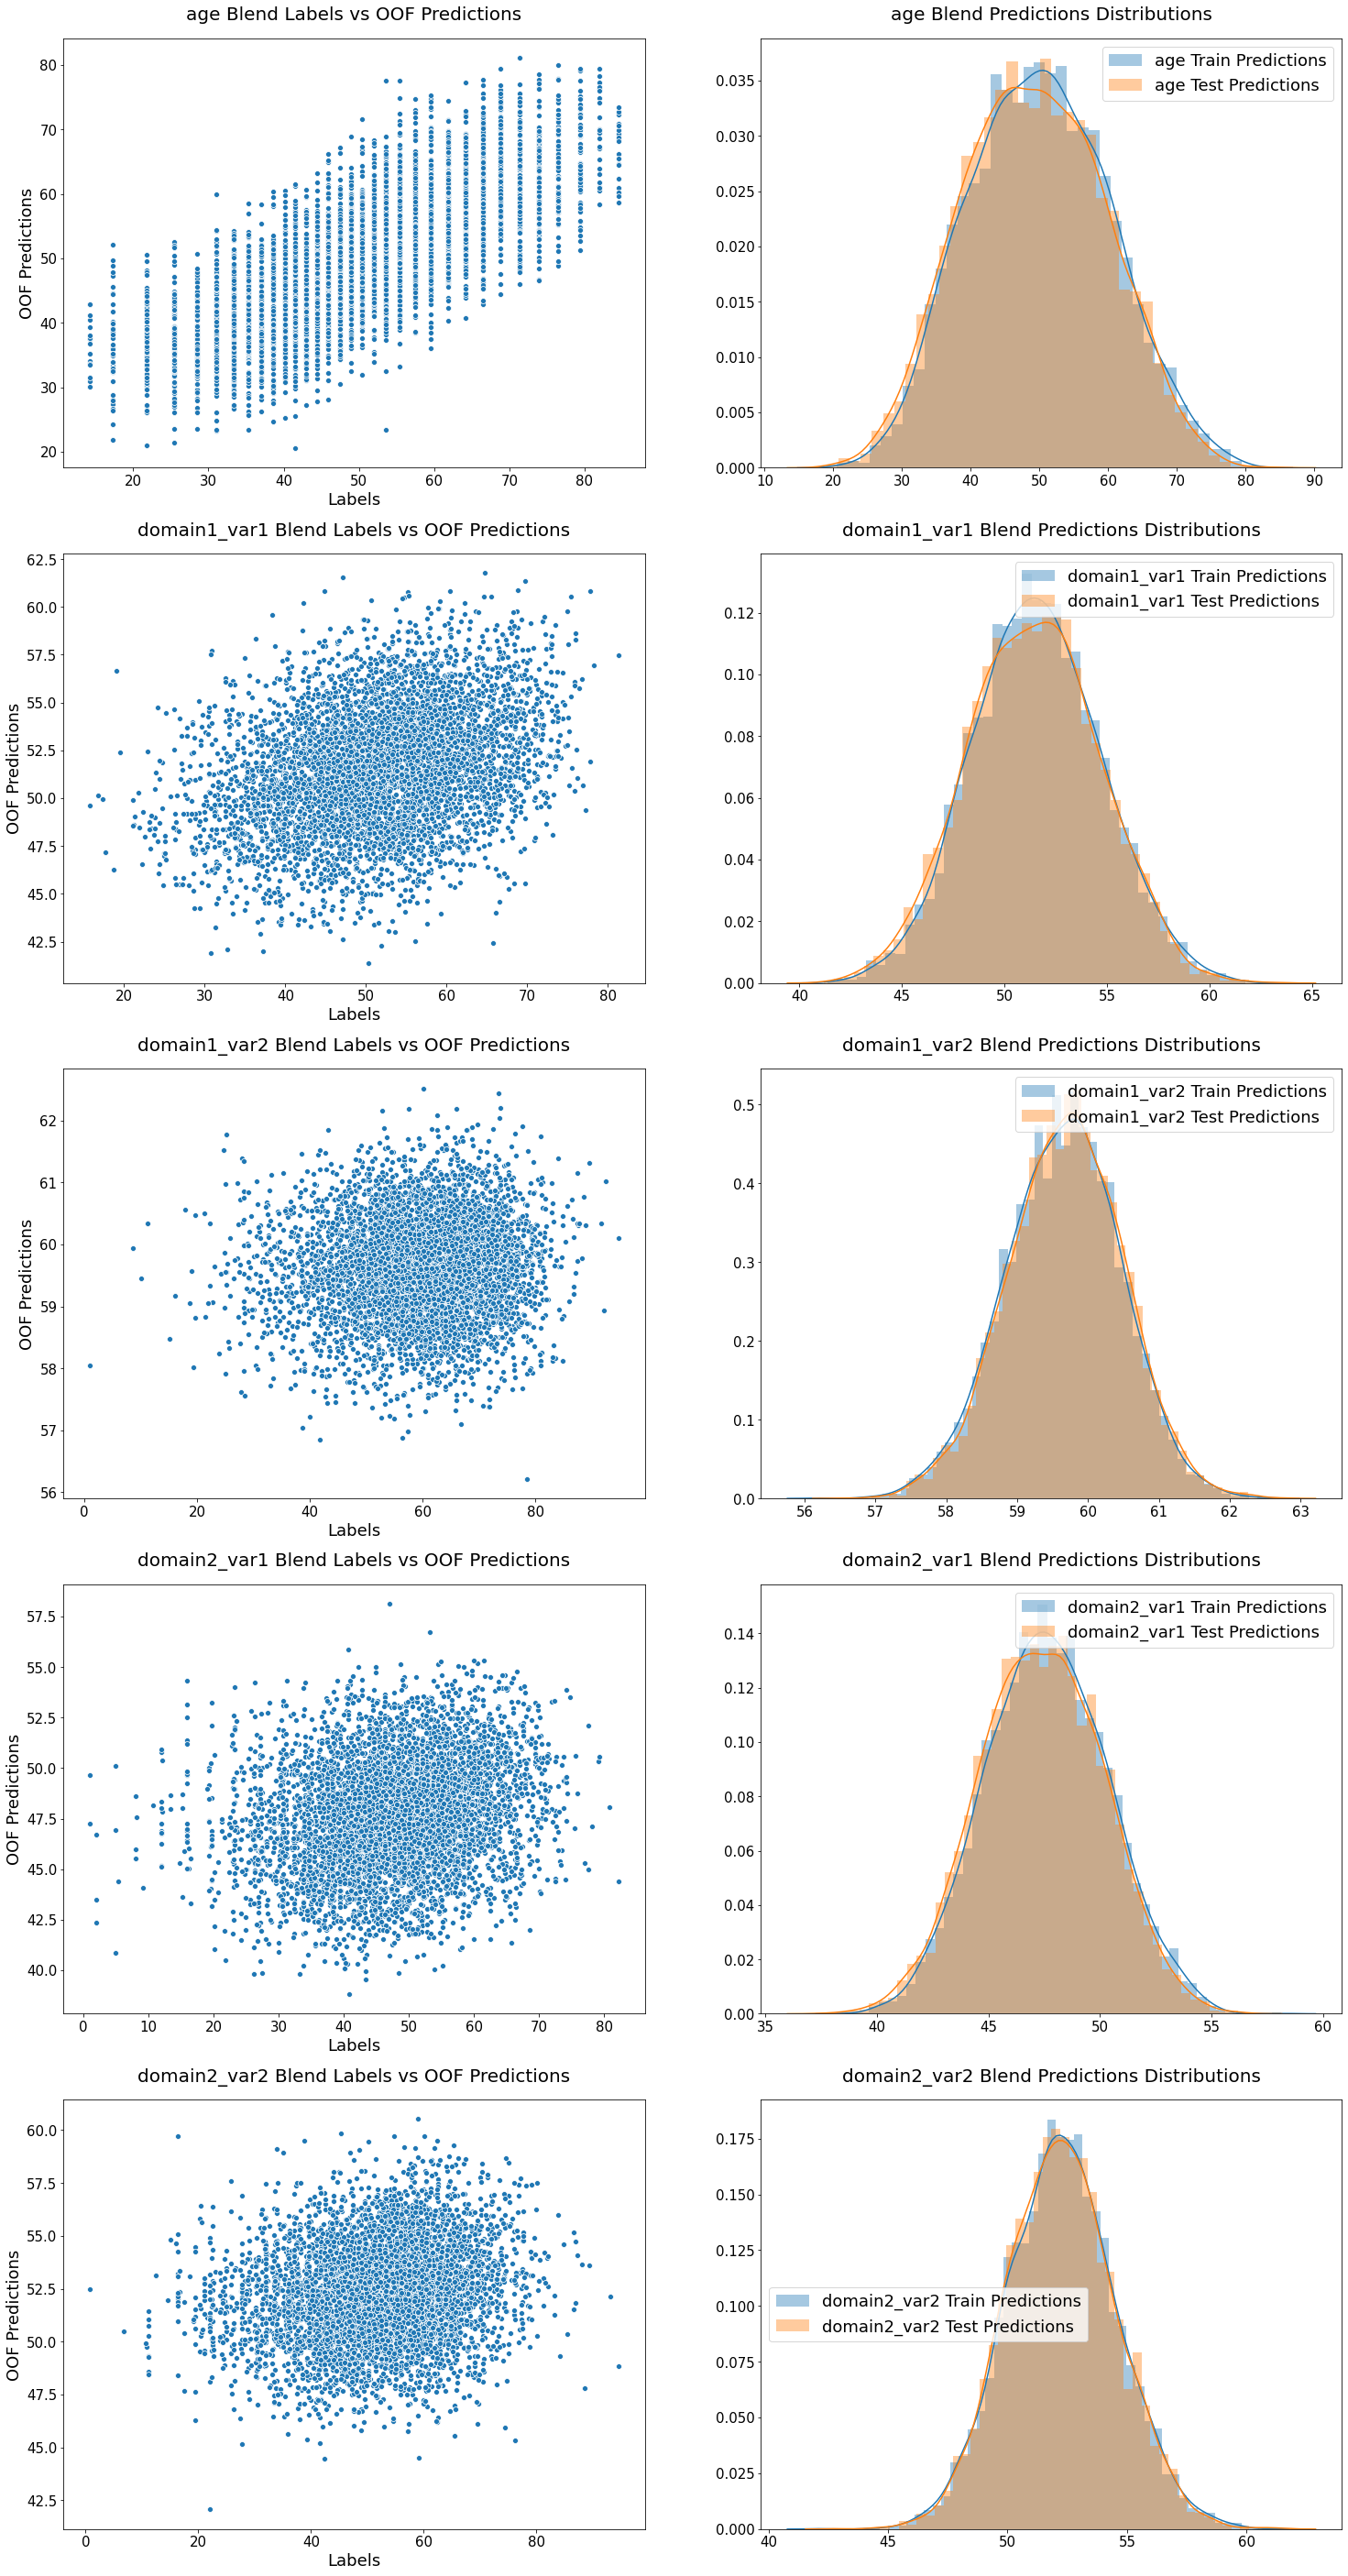

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25, 50))

for i, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

    target_oof_predictions = df_train.loc[linear_model_ensemble.target_idx[target], f'blend_{target}']
    target_y_true = df_train.loc[linear_model_ensemble.target_idx[target], target]  
    target_test_predictions = df_test.loc[:, f'blend_{target}']

    sns.scatterplot(target_y_true, target_oof_predictions, ax=axes[i][0])
    sns.distplot(target_oof_predictions, label=f'{target} Train Predictions', ax=axes[i][1])
    sns.distplot(target_test_predictions, label=f'{target} Test Predictions', ax=axes[i][1])

    axes[i][0].set_xlabel(f'Labels', size=18)
    axes[i][0].set_ylabel(f'OOF Predictions', size=18)
    axes[i][1].set_xlabel('')
    axes[i][1].legend(prop={'size': 18})
    for j in range(2):
        axes[i][j].tick_params(axis='x', labelsize=15)
        axes[i][j].tick_params(axis='y', labelsize=15)
    axes[i][0].set_title(f'{target} Blend Labels vs OOF Predictions', size=20, pad=20)
    axes[i][1].set_title(f'{target} Blend Predictions Distributions', size=20, pad=20)

plt.show()

It can be seen that most of the error is coming from the first decile in all target features. This problem is related to both competition metric, normalized absolute error and target distributions. Values closer to target means are easier to predict, so error is smaller in those deciles, however, values closer to distribution tails are harder to predict so error is greater in first and last deciles.

In [12]:
def get_score_by_deciles(target, predictions):
    y_true = df_train[target]
    y_pred = df_train[predictions]
    
    print(f'{target} NAE in Deciles\n{("-" * (15 + len(target)))}')
    
    deciles = np.arange(0, 1, 0.1)
    
    for decile in deciles:
        decile_lower_bound = y_true.quantile(decile)
        decile_upper_bound = y_true.quantile(decile + 0.1)
        
        decile_y_true = y_true.loc[(y_true >= decile_lower_bound) & (y_true < decile_upper_bound)]
        decile_y_pred = y_pred.loc[(y_true >= decile_lower_bound) & (y_true < decile_upper_bound)]
        
        decile_nae = normalized_absolute_error(decile_y_true, decile_y_pred)        
        print(f'Decile: {decile:.6}-{decile + 0.1:.6} ({decile_lower_bound:.6}-{decile_upper_bound:.6}) NAE {decile_nae:.6}')
    global_nae = normalized_absolute_error(y_true, y_pred)   
    print(f'{("-" * (15 + len(target)))}\n{target} Global NAE {global_nae:.6}\n')

for target in target_features:
    get_score_by_deciles(target, f'blend_{target}')

age NAE in Deciles
------------------
Decile: 0.0-0.1 (14.2573-33.4047) NAE 0.454927
Decile: 0.1-0.2 (33.4047-38.6174) NAE 0.185793
Decile: 0.2-0.3 (38.6174-42.9412) NAE 0.147154
Decile: 0.3-0.4 (42.9412-45.8882) NAE 0.121362
Decile: 0.4-0.5 (45.8882-50.4277) NAE 0.113263
Decile: 0.5-0.6 (50.4277-53.5838) NAE 0.0997202
Decile: 0.6-0.7 (53.5838-57.4361) NAE 0.102621
Decile: 0.7-0.8 (57.4361-61.8114) NAE 0.09761
Decile: 0.8-0.9 (61.8114-68.8209) NAE 0.108035
Decile: 0.9-1.0 (68.8209-84.4911) NAE 0.141789
------------------
age Global NAE 0.1382

domain1_var1 NAE in Deciles
---------------------------
Decile: 0.0-0.1 (15.7692-38.1417) NAE 0.512315
Decile: 0.1-0.2 (38.1417-42.889) NAE 0.243197
Decile: 0.2-0.3 (42.889-46.2362) NAE 0.140037
Decile: 0.3-0.4 (46.2362-49.1955) NAE 0.0783573
Decile: 0.4-0.5 (49.1955-51.8481) NAE 0.0515815
Decile: 0.5-0.6 (51.8481-54.3586) NAE 0.0514855
Decile: 0.6-0.7 (54.3586-57.0703) NAE 0.0752231
Decile: 0.7-0.8 (57.0703-60.1581) NAE 0.108953
Decile: 0.8-0.9 

In [13]:
column_mapping = {'blend_age': 'age', 
                  'blend_domain1_var1': 'domain1_var1',
                  'blend_domain1_var2': 'domain1_var2',
                  'blend_domain2_var1': 'domain2_var1', 
                  'blend_domain2_var2': 'domain2_var2'}

df_submission = pd.melt(df_test.rename(columns=column_mapping)[['Id', 'age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']], id_vars=['Id'], value_name='Predicted')
df_submission['Id'] = df_submission['Id'].astype('str') + '_' +  df_submission['variable'].astype('str')
df_submission = df_submission.drop(columns=['variable']).sort_values('Id')
df_submission.to_csv('linear_model_blend_submission.csv', index=False)

df_submission.head(10)

Id  Predicted
0               10003_age  53.070824
5877   10003_domain1_var1  48.514436
11754  10003_domain1_var2  60.139712
17631  10003_domain2_var1  48.789067
23508  10003_domain2_var2  57.457415
1               10006_age  62.711862
5878   10006_domain1_var1  54.013086
11755  10006_domain1_var2  59.099737
17632  10006_domain2_var1  50.298904
23509  10006_domain2_var2  51.118314